# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

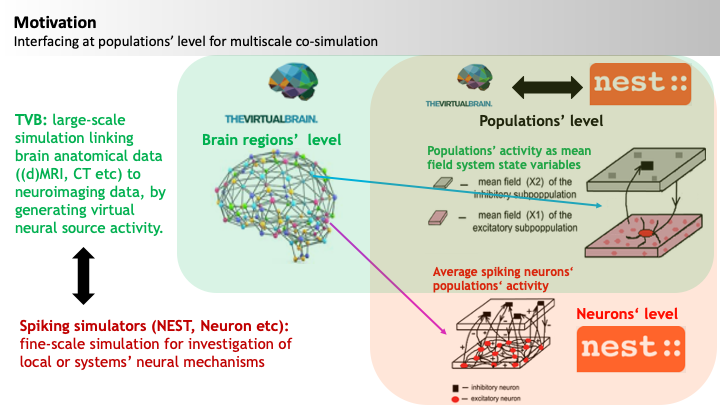

In [1]:
from IPython.core.display import Image, display
display(Image(filename='pics/ConceptGraph1.png',  width=1000, unconfined=False))

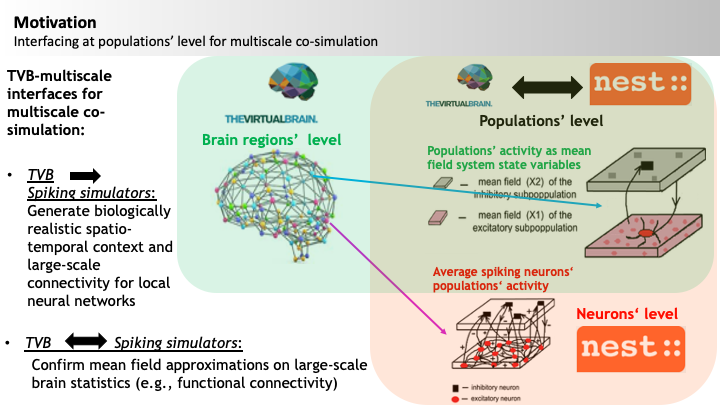

In [2]:
display(Image(filename='pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Wilson - Cowan TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

Population activity dynamics (1 excitatory and 1 inhibitory population):

 $\dot{E}_k = \dfrac{1}{\tau_e} (-E_k  + (k_e - r_e E_k) \mathcal{S}_e (\alpha_e \left( c_{ee} E_k - c_{ei} I_k  + P_k - \theta_e + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) )) $
 
$
            \dot{I}_k = \dfrac{1}{\tau_i} (-I_k  + (k_i - r_i I_k) \mathcal{S}_i (\alpha_i \left( c_{ie} E_k - c_{ee} I_k  + Q_k - \theta_i + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) ))$


## Spiking network model in NEST

using "iaf_cond_alpha" spiking neuronal model.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * E(t) $, 

Inhomogeneous spike generator NEST devices are used as TVB "proxy" nodes and generate independent Poisson-random spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Alternatively, the spike trains are generated outside NEST using the Elephant software and inserted to NEST via spike generator devices.



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {E_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E * dt} $ 

$ {I_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I * dt} $

in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., minimally 2) NEST time steps for every 1 TVB time step for stable integration

### Synchronizaion every minimum delay time between the two simulators.

# WORKFLOW:

In [3]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
SIM_MODE = "tvb-nest"  # "tvb-nest" or "tvb" ("nest") for only TVB (NEST) simulation
NEST_MODEL_BUILDERS = "opinionated" #  None, "opinionated", "nonopinionated"
if SIM_MODE.lower().find("nest") > -1:
    COSIM_MODE = "ray-parallel" #"ray-parallel", "serial",  "ray-serial" (only for testing)
else:
    COSIM_MODE = "serial"
# -----------------------------------------------

work_path = os.getcwd()
outputs_path = os.path.join(work_path, "outputs/WilsonCowan")
if NEST_MODEL_BUILDERS is None:
    outputs_path += "NoNestBuilders"
elif NEST_MODEL_BUILDERS == "opinionated":
    outputs_path += "OpinionBuilders"
elif NEST_MODEL_BUILDERS == "nonopinionated":
    outputs_path += "NonOpinionBuilders"
    
if SIM_MODE.lower() == "nest":
    outputs_path += "NESTonly"
elif SIM_MODE.lower() == "tvb":
    outputs_path += "TVBonly"
    
config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-06-25 18:00:17,066 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-06-25 18:00:17,066 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-06-25 18:00:17,070 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-06-25 18:00:17,070 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-06-25 18:00:17,073 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-06-25 18:00:17,073 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-06-25 18:00:17,077 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-06-25 18:00:17,077 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-06-25 18:00:17,080 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [4]:
from tvb_multiscale.core.tvb.cosimulator.models.wilson_cowan_constraint import WilsonCowan


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
# -----------------------------------Wilson Cowan oscillatory regime--------------------------------
model_params = {
        "r_e": np.array([0.0]),
        "r_i": np.array([0.0]),
        "k_e": np.array([1.0]),
        "k_i": np.array([1.0]),
        "tau_e": np.array([10.0]),
        "tau_i": np.array([10.0]),
        "c_ee": np.array([10.0]),
        "c_ei": np.array([6.0]),
        "c_ie": np.array([10.0]),
        "c_ii": np.array([1.0]),
        "alpha_e": np.array([1.2]),
        "alpha_i": np.array([2.0]),
        "a_e": np.array([1.0]),
        "a_i": np.array([1.0]),
        "b_e": np.array([0.0]),
        "b_i": np.array([0.0]),
        "c_e": np.array([1.0]),
        "c_i": np.array([1.0]),
        "theta_e": np.array([2.0]),
        "theta_i": np.array([3.5]),
        "P": np.array([0.5]),
        "Q": np.array([0.0])
    }


# -----------------------------------Build cosimunlator manually--------------------------------
if COSIM_MODE.lower().find("parallel") > -1:
    from tvb_multiscale.core.tvb.cosimulator.cosimulator_parallel \
        import CoSimulatorRay as CoSimulator
else:
    from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial \
        import CoSimulatorSerial as CoSimulator
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG

simulator = CoSimulator()

simulator.model = WilsonCowan(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([config.DEFAULT_NSIG, config.DEFAULT_NSIG]) # 0.001


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

# connectivity.tract_lengths = np.maximum(connectivity.speed * simulator.integrator.dt, 
#                                         connectivity.tract_lengths)

connectivity.configure()

simulator.connectivity = connectivity

simulator.initial_conditions = np.zeros((1, 2, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.configure()


# # -----------------------------------Or use the CoSimulator builder--------------------------------
# from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorSerialBuilder

# simulator_builder = CoSimulatorSerialBuilder()
# simulator_builder.config = config
# simulator_builder.model = WilsonCowan()
# simulator_builder.model_params = model_params
# simulator_builder.initial_conditions = np.zeros((1, 1, 1, 1))

# simulator_builder.configure()

# simulator = simulator_builder.build()


# Plot TVB connectome:
# plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [5]:
nest_nodes_inds = []

if SIM_MODE.lower().find("nest") > -1:

    config.DEFAULT_LOCAL_NUM_THREADS = 1
    
    # Build a NEST network model with the corresponding builder
    from tvb_multiscale.tvb_nest.nest_models.models.cereb_no_tvb_nest_builders \
        import CerebBuilder as CerebBuilderNoNESTbuilder

    # Load NEST and use defaults to configure its kernel:

    if COSIM_MODE.lower().find("ray") > -1:
        from tvb_multiscale.tvb_nest.nest_models.nest_ray import RayNESTServer, RayNESTClient
        import ray
        ray.init()
        RayNESTServer = ray.remote(RayNESTServer)
        nest_server = \
            RayNESTServer.options(name="nest_server", 
                                  num_cpus=config.DEFAULT_LOCAL_NUM_THREADS).remote(config=config)
        nest = RayNESTClient(nest_server)    
    else:
        from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest, configure_nest_kernel
        nest = configure_nest_kernel(load_nest(config=config), config)


    # Select the brain region nodes to place spiking networks at:
    nest_nodes_inds = np.array([0, 1]) 

    if NEST_MODEL_BUILDERS:

        if NEST_MODEL_BUILDERS == "nonopinionated":

            # ------------------- Instantiating an opinionated nest network builder for this model, ------------------- 
            # using all default parameters for this example

            from tvb_multiscale.tvb_nest.nest_models.models.wilson_cowan import WilsonCowanBuilder

            nest_model_builder = WilsonCowanBuilder(
                simulator, spiking_nodes_inds=nest_nodes_inds, nest_instance=nest, config=config)

            # ... or modifying some of the builder's attributes:
            nest_model_builder.w_ee = simulator.model.c_ee[0]
            nest_model_builder.w_ei = simulator.model.c_ei[0]
            nest_model_builder.w_ie = -simulator.model.c_ie[0]
            nest_model_builder.w_ii = -simulator.model.c_ii[0]
            nest_model_builder.output_devices_record_to = "memory"  # "ascii"
            nest_model_builder.populations_order = 100
            nest_model_builder.tvb_to_spiking_dt_ratio = 2 # 2 NEST integration steps for 1 TVB integration step
            nest_model_builder.monitor_period = 1.0

        else:

            # ------ Alternatively, instantiating an opinionated nest network builder for this model, ----------------- 
            # ... and setting desired network description:

            from tvb_multiscale.tvb_nest.nest_models.builders.base import NESTNetworkBuilder

            nest_model_builder = NESTNetworkBuilder(
                simulator, spiking_nodes_inds=nest_nodes_inds, nest_instance=nest, config=config)
            nest_model_builder.output_devices_record_to = "memory"  # "ascii"
            nest_model_builder.populations_order = 100
            nest_model_builder.tvb_to_spiking_dt_ratio = 2 # 2 NEST integration steps for 1 TVB integration step
            nest_model_builder.monitor_period = 1.0

            # Set populations:
            nest_model_builder.populations = []
            for pop in ["E", "I"]:
                nest_model_builder.populations.append(
                    {"label": pop, 
                     "model": config.DEFAULT_MODEL,  # "iaf_cond_alpha" by default
                     # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                     "params": {},   # parameters for NEST neuronal model
                     "scale": 1.0,   # nest_model_builder.multiply populations_order for the exact populations' size
                     # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                     "nodes": None}) # None means "all" -> building this population to all spiking_nodes_inds


            # "static_synapse" by default:
            synapse_model = config.DEFAULT_CONNECTION["synapse_model"] 
            # Default conn_spec: {'rule': "all_to_all", "allow_autapses": True, 'allow_multapses': True}
            conn_spec =  config.DEFAULT_CONNECTION["conn_spec"]  

            # Set populations' connections within brain region nodes
            nest_model_builder.populations_connections = [
                {"source": "E", "target": "E",  # E -> E This is a self-connection for population "E"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "synapse_model": synapse_model,  
                 "conn_spec": conn_spec,
                 "weight": simulator.model.c_ee[0], # default = 1.0
                 "delay": 0.1, # by default = 1 TVB time step
                 "receptor_type": 0, # default = 0
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None}, # None means "all" -> performing this connection to all spiking_nodes_inds
                {"source": "E", "target": "I",  # E -> I
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": simulator.model.c_ei[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None},
                {"source": "I", "target": "E",  # I -> E
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": -simulator.model.c_ie[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None},
                {"source": "I", "target": "I",  # I -> I, This is a self-connection for population "I"
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": -simulator.model.c_ii[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None}
            ]

            # Set populations' connections among brain region node:
            nest_model_builder.nodes_connections = [
                {"source": "E", "target": ["E", "I"],
                 #--------- Possibly functions of (source_node_ind, target_node_ind, *args, **kwargs) -------------
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec,
                 # ...using TVB connectome weights:
                 "weight": 
                     lambda source_node_ind, target_node_ind: 
                         simulator.coupling.a[0] * simulator.connectivity.weights[source_node_ind, target_node_ind], 
                 # ...using TVB connectome delays
                 "delay": lambda source_node_ind, target_node_ind: 
                         np.maximum(simulator.integrator.dt, 
                                    simulator.connectivity.delays[source_node_ind, target_node_ind]),   
                 "receptor_type": 0, 
                 #--------- Possibly functions of (source_node_ind, target_node_ind, *args, **kwargs) -------------
                 "source_nodes": None,  # None means "all" -> performing this connection from all spiking_nodes_inds
                 "target_nodes": None}  # None means "all" -> performing this connection to all spiking_nodes_inds
            ]

            # Set output recorder devices:
            params_spike_recorder = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_recorder"].copy()
            params_spike_recorder["record_to"] = nest_model_builder.output_devices_record_to
            params_multimeter = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"].copy()
            params_multimeter["record_to"] = nest_model_builder.output_devices_record_to
            params_multimeter["interval"] = nest_model_builder.monitor_period
            nest_model_builder.output_devices = [
                {"model": "spike_recorder", 
                 "connections": {"E": "E",   # Record spikes with label "E" from populations "E"
                                 "I": "I"},  # Record spikes with label "I" from populations "I"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": params_spike_recorder,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None},  # None means all here -> recording from all spiking_nodes_inds
                {"model": "multimeter", 
                 "connections": {"Excitatory": "E",   # Record time series with label "E_ts" from populations "E"
                                 "Inhibitory": "I"},  # Record time series with label "I_ts" from populations "I"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": params_multimeter,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None},  # None means all here -> recording from all spiking_nodes_inds

            ]


            # Set input stimulation devices:
            nest_model_builder.input_devices = [
                {"model": "poisson_generator",
                "connections": {"Stimulus": "E"}, # connect stimulus "Stimulus" to populations "E"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": {"rate": 7000.0, "origin": 0.0, "start": 0.1}, 
                 "weights": 1.0,
                 "delays": 0.1,
                 "receptor_type": 0,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                "nodes": None  # None means all here -> stimulating all spiking_nodes_inds
                }

            ]


        nest_model_builder.configure()

        nest_network = nest_model_builder.build()



    else:

        # ------------------- Construct the NEST network model manually ------------------- 

        from tvb_multiscale.tvb_nest.nest_models.network import NESTNetwork
        from tvb_multiscale.tvb_nest.nest_models.brain import NESTBrain
        from tvb_multiscale.tvb_nest.nest_models.region_node import NESTRegionNode
        from tvb_multiscale.tvb_nest.nest_models.population import NESTPopulation
        from tvb_multiscale.core.spiking_models.devices import DeviceSet
        from tvb_multiscale.tvb_nest.nest_models.devices import NESTSpikeRecorder, NESTMultimeter
        from tvb_multiscale.tvb_nest.nest_models.devices import NESTPoissonGenerator


        # First configure NEST kernel:
        nest.SetKernelStatus({"resolution": 0.05})

        print("Building NESTNetwork...")

        # Create NEST network...
        nest_network = NESTNetwork(nest)


        # ...starting from neuronal populations located at specific brain regions...
        nest_network.brain_regions = NESTBrain()
        model = config.DEFAULT_MODEL
        for node_ind in nest_nodes_inds:
            region_name = simulator.connectivity.region_labels[node_ind]
            if region_name not in nest_network.brain_regions.keys():
                nest_network.brain_regions[region_name] = NESTRegionNode(label=region_name)
            for pop in ["E", "I"]:
                nest_network.brain_regions[region_name][pop] = \
                           NESTPopulation(nest.Create(config.DEFAULT_MODEL, 100), # possible NEST model params as well here
                                          nest, label=pop, brain_region=region_name)
                print("\n...created: %s..." % nest_network.brain_regions[region_name][pop].print_str())

        # "static_synapse" by default:
        synapse_model = config.DEFAULT_CONNECTION["synapse_model"] 
        # Default 
        conn_spec = {'rule': "all_to_all", "allow_autapses": True, 'allow_multapses': True}


        # Connecting populations...
        for src_node_ind in nest_nodes_inds: 
            src_node_lbl = simulator.connectivity.region_labels[src_node_ind]
            for trg_node_ind in nest_nodes_inds: 
                trg_node_lbl = simulator.connectivity.region_labels[trg_node_ind]

                if src_node_ind == trg_node_ind:
                    # ...within brain regions...:
                    for src_pop, trg_pop, w in zip(["E", "E", "I", "I"], 
                                                   ["E", "I", "E", "I"], 
                                                   [simulator.model.c_ee[0].item(), 
                                                    simulator.model.c_ei[0].item(), 
                                                    -simulator.model.c_ie[0].item(), 
                                                    -simulator.model.c_ii[0].item()]):
                        nest.Connect(nest_network.brain_regions[src_node_lbl][src_pop].nodes, 
                                     nest_network.brain_regions[src_node_lbl][trg_pop].nodes, 
                                     syn_spec={"synapse_model": synapse_model, 
                                               "weight": w, "delay": 0.1, "receptor_type": 0}, 
                                     conn_spec=conn_spec)
                        print("\n...connected populations %s -> %s in brain region %s..." 
                              % (src_pop, trg_pop, src_node_lbl))
                else:

                    # ...between brain regions...:
                    nest.Connect(nest_network.brain_regions[src_node_lbl]["E"].nodes, 
                                 nest.NodeCollection(nest_network.brain_regions[trg_node_lbl]["E"].gids 
                                                     + nest_network.brain_regions[trg_node_lbl]["I"].gids), 
                                 syn_spec={"synapse_model": synapse_model, 
                                           "weight": simulator.coupling.a[0].item() * 
                                                     simulator.connectivity.weights[src_node_ind, trg_node_ind].item(), 
                                           "delay": np.maximum(0.1, 
                                                               simulator.connectivity.delays[src_node_ind, trg_node_ind].item()),
                                           "receptor_type": 0}, 
                                 conn_spec=conn_spec)
                    print("\n...connected populations E - %s -> [E, I] - %s..." % (src_node_lbl, trg_node_lbl))


        # Create output recorder devices:
        params_spike_recorder = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_recorder"].copy()
        params_spike_recorder["record_to"] = "memory"
        params_multimeter = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"].copy()
        params_multimeter["record_to"] = "memory"
        params_multimeter["interval"] = 1.0
        for pop in ["E", "I"]:
            nest_network.output_devices[pop] = DeviceSet(label=pop, model="spike_recorder")
            pop_lbl = np.where(pop == "E", "Excitatory", "Inhibitory").item()
            nest_network.output_devices[pop_lbl] = DeviceSet(label=pop_lbl, model="multimeter")
            for node_ind in nest_nodes_inds:
                region_name = simulator.connectivity.region_labels[node_ind]

                # Create and connect population spike recorder for this region:
                nest_network.output_devices[pop][region_name] = \
                    NESTSpikeRecorder(nest.Create("spike_recorder", 1, params=params_spike_recorder), 
                                      nest, model="spike_recorder", label=pop, brain_region=region_name)
                nest.Connect(nest_network.brain_regions[region_name][pop].nodes, 
                             nest_network.output_devices[pop][region_name].device)
                nest_network.output_devices[pop].update() # update DeviceSet after the new NESTDevice entry
                print("\n...created spike_recorder device for population %s in brain region %s..." % (pop, region_name))

                # Create and connect population multimeter for this region:
                nest_network.output_devices[pop_lbl][region_name] = \
                    NESTMultimeter(nest.Create("multimeter", 1, params=params_multimeter), 
                                   nest, model="multimeter", label=pop_lbl, brain_region=region_name)
                nest.Connect(nest_network.output_devices[pop_lbl][region_name].device, 
                             nest_network.brain_regions[region_name][pop].nodes)
                nest_network.output_devices[pop_lbl].update() # update DeviceSet after the new NESTDevice entry
                print("\n...created multimeter device for population %s in brain region %s..." % (pop, region_name))


        # Create input stimulation devices:
        nest_network.input_devices["Stimulus"] = DeviceSet(label="Stimulus", model="poisson_generator")
        for node_ind in nest_nodes_inds:
                region_name = simulator.connectivity.region_labels[node_ind]
                # Create and connect population spike recorder for this region:
                nest_network.input_devices["Stimulus"][region_name] = \
                    NESTPoissonGenerator(nest.Create("poisson_generator", 1, 
                                                     params={"rate": 7000.0, "origin": 0.0, "start": 0.1}), 
                                         nest, model="poisson_generator", label="Stimulus", brain_region=region_name)
                nest.Connect(nest_network.input_devices["Stimulus"][region_name].device,
                             nest_network.brain_regions[region_name]["E"].nodes, 
                             syn_spec={"weight": 1.0, "delay": 0.1})
                nest_network.input_devices["Stimulus"].update()  # update DeviceSet after the new NESTDevice entry
                print("\n...created poisson_generator device for population E in brain region %s..." % region_name)   



    # Configure NESTNetwork class:
    nest_network.configure()

    print(nest_network.print_str(connectivity=True))


2021-06-25 18:00:22,625	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265
2021-06-25 18:00:22,631	WARNING services.py:1740 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=5.06gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


(pid=168) 2021-06-25 18:00:26,031 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
(pid=168) 2021-06-25 18:00:26,031 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
(pid=168) 2021-06-25 18:00:26,033 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
(pid=168) 2021-06-25 18:00:26,033 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
(pid=168) 2021-06-25 18:00:26,034 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
(pid=168) 2021-06-25 18:00:26,034 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
(pid=168) 2021-06-25 18:00:26,035 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
(pid=168) 2021-06-25 18:00:26,035 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neuro

(pid=168) 
(pid=168)               -- N E S T --
(pid=168)   Copyright (C) 2004 The NEST Initiative
(pid=168) 
(pid=168)  Version: HEAD@1e0ce51e1
(pid=168)  Built: Jun  7 2021 13:35:35
(pid=168) 
(pid=168)  This program is provided AS IS and comes with
(pid=168)  NO WARRANTY. See the file LICENSE for details.
(pid=168) 
(pid=168)  Problems or suggestions?
(pid=168)    Visit https://www.nest-simulator.org
(pid=168) 
(pid=168)  Type 'nest.help()' to find out more about NEST.
(pid=168) 
2021-06-25 18:00:26,633 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-06-25 18:00:26,633 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-06-25 18:00:26,635 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-06-25 18:00:26,635 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-06-25 18:00:26,638 - INFO - tvb_multis

2021-06-25 18:00:26,842 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...10000 connections to receptor 0
2021-06-25 18:00:26,854 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations among spiking brain regions...
2021-06-25 18:00:26,854 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations among spiking brain regions...
2021-06-25 18:00:26,857 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 0 -> 1 spiking region nodes ...
2021-06-25 18:00:26,857 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting for 0 -> 1 spiking region nodes ...
2021-06-25 18:00:26,860 - INFO - tvb_multiscale.core.spiking_models.builders.base - E -> E populations ...
2021-06-25 18:00:26,860 - INFO - tvb_multiscale.core.spiking_models.builders.base - E -> E populations ...
2021-06-25 18:00:26,865 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...10000 connections to receptor 0
2021-06-

## 3. Build the TVB-NEST interface

In [6]:
if np.all(SIM_MODE.lower() == "tvb-nest"):
    
    # Build a TVB-NEST interface with all the appropriate connections between the
    # TVB and NEST modelled regions
    
    # ---------------------------- Opinionated TVB<->NEST interface builder----------------------------
    from tvb_multiscale.tvb_nest.interfaces.models.wilson_cowan import WilsonCowanTVBNESTInterfaceBuilder   
    tvb_spikeNet_model_builder =  WilsonCowanTVBNESTInterfaceBuilder()  # opinionated builder
    
#     # ---------------------------- Non opinionated TVB<->NEST interface builder----------------------------
#     from tvb_multiscale.tvb_nest.interfaces.builders import TVBNESTInterfaceBuilder   
#     tvb_spikeNet_model_builder =  TVBNESTInterfaceBuilder()  # non opinionated builder
    
    
    # Basic configurations:
    tvb_spikeNet_model_builder.config = config
    tvb_spikeNet_model_builder.tvb_cosimulator = simulator              
    tvb_spikeNet_model_builder.spiking_network = nest_network
    # This can be used to set default tranformer and proxy models:
    tvb_spikeNet_model_builder.model = "RATE"          # "RATE" (or "SPIKES", "CURRENT") TVB->NEST interface
    tvb_spikeNet_model_builder.input_flag = True   # If True, NEST->TVB update will be implemented
    tvb_spikeNet_model_builder.output_flag = True  # If True, TVB->NEST coupling will be implemented
    # If default_coupling_mode = "TVB", large scale coupling towards spiking regions is computed in TVB
    # and then applied with no time delay via a single "TVB proxy node" / NEST device for each spiking region,
    # "1-to-1" TVB->NEST coupling.
    # If any other value, we need 1 "TVB proxy node" / NEST device for each TVB sender region node, and
    # large-scale coupling for spiking regions is computed in NEST, 
    # taking into consideration the TVB connectome weights and delays, 
    # in this "1-to-many" TVB->NEST coupling.
    tvb_spikeNet_model_builder.default_coupling_mode = "TVB" 
    # Number of neurons per population to be used to compute population mean instantaneous firing rates:
    tvb_spikeNet_model_builder.N_E = nest_network.brain_regions[nest_nodes_inds[0]]["E"].number_of_neurons
    tvb_spikeNet_model_builder.N_I = nest_network.brain_regions[nest_nodes_inds[0]]["I"].number_of_neurons
    tvb_spikeNet_model_builder.proxy_inds = nest_nodes_inds
    # Set exclusive_nodes = True (Default) if the spiking regions substitute for the TVB ones:
    tvb_spikeNet_model_builder.exclusive_nodes = True  

    tvb_spikeNet_model_builder.output_interfaces = []
    tvb_spikeNet_model_builder.input_interfaces = []
    
    

    

In [7]:
if np.all(SIM_MODE.lower() == "tvb-nest"):
    # Options for a nonopinionated builder:
    from tvb_multiscale.core.interfaces.base.transformers.builders import \
        DefaultTVBtoSpikeNetTransformers, DefaultSpikeNetToTVBTransformers, \
        DefaultTVBtoSpikeNetModels, DefaultSpikeNetToTVBModels
    from tvb_multiscale.tvb_nest.interfaces.builders import \
        TVBtoNESTModels, NESTInputProxyModels, DefaultTVBtoNESTModels, \
        NESTtoTVBModels, NESTOutputProxyModels, DefaultNESTtoTVBModels

    
    def print_enum(enum):
        print("\n", enum)
        for name, member in enum.__members__.items():
            print(name,"= ", member.value)
    
    
    print("Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:")
    print_enum(TVBtoNESTModels)
    print_enum(NESTtoTVBModels)
    
    
    print("\n\nAvailable input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:")

    print_enum(DefaultTVBtoSpikeNetModels)
    print_enum(DefaultTVBtoSpikeNetTransformers)
    
    print_enum(DefaultSpikeNetToTVBModels)
    print_enum(DefaultSpikeNetToTVBTransformers)    
    
    
    print("\n\nAvailable input (NEST->TVB update) / output (TVB->NEST coupling) proxy models:")

    print_enum(DefaultTVBtoNESTModels)
    print_enum(NESTInputProxyModels)
    
    print_enum(NESTOutputProxyModels)
    print_enum(DefaultNESTtoTVBModels)

    

Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:

 <enum 'TVBtoSpikeNetModels'>
RATE =  0
SPIKES =  1
CURRENT =  2

 <enum 'SpikeNetToTVBModels'>
SPIKES =  1


Available input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:

 <enum 'DefaultTVBtoSpikeNetModels'>
RATE =  RATE
SPIKES =  SPIKES_SINGLE_INTERACTION
CURRENT =  CURRENT

 <enum 'DefaultTVBtoSpikeNetTransformers'>
RATE =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.base.ScaleRate'>
SPIKES =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoisson'>
SPIKES_SINGLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonSingleInteraction'>
SPIKES_MULTIPLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonMultipleInteraction'>
CURRENT =  <class 'tvb_multiscale.core.interfaces.base.t

In [8]:
if np.all(SIM_MODE.lower() == "tvb-nest"):

    # Using all default parameters for this example of an opinionated builder
    tvb_spikeNet_model_builder.default_config()
   
    
#     # or setting a nonopinionated builder:
#     from tvb_multiscale.core.interfaces.tvb.interfaces import TVBtoSpikeNetModels
    
#     tvb_spikeNet_model_builder.output_interfaces = \
#         [{'voi': np.array(["E"]),         # TVB state variable to get data from
#           'populations': np.array(["E"]), # NEST populations to couple to
#         # --------------- Arguments that can default if not given by the user:------------------------------
#           'model': 'RATE',                # This can be used to set default tranformer and proxy models
#           'coupling_mode': 'TVB',         # or "spikeNet", "NEST", etc
#           'proxy_inds': nest_nodes_inds,  # TVB proxy region nodes' indices
#           # Set the enum entry or the corresponding label name for the "proxy_model", 
#           # or import and set the appropriate NEST proxy device class, e.g., NESTInhomogeneousPoissonGeneratorSet, directly
#           # options: "RATE", "RATE_TO_SPIKES", SPIKES", "PARROT_SPIKES" or CURRENT"
#           # see tvb_multiscale.tvb_nest.interfaces.io.NESTInputProxyModels for options and related NESTDevice classes, 
#           # and tvb_multiscale.tvb_nest.interfaces.io.DefaultTVBtoNESTModels for the default choices
#           'proxy_model': "RATE",  
#           # Set the enum entry or the corresponding label name for the "transformer_model", 
#           # or import and set the appropriate tranformer class, e.g., ScaleRate, directly
#           # options: "RATE", "SPIKES", "SPIKES_SINGE_INTERACTION", "SPIKES_MULTIPLE_INTERACTION", "CURRENT"
#           # see tvb_multiscale.core.interfaces.base.transformers.models.DefaultTVBtoSpikeNetTransformers for options and related Transformer classes,
#           # and tvb_multiscale.core.interfaces.base.transformers.models.DefaultTVBtoSpikeNetModels for default choices
#           'transformer_model': "RATE",  
#           'spiking_proxy_inds': nest_nodes_inds  # Same as "proxy_inds" for this kind of interface
#          }
#         ]
    
#     for interface in tvb_spikeNet_model_builder.output_interfaces:
#         # The "scale_factor" scales the TVB state variable to convert it to an 
#         # instantaneous rate:
#         if tvb_spikeNet_model_builder.model == TVBtoSpikeNetModels.SPIKES.name:
#             # The "number_of_neurons" will determine how many spike trains will be generated:
#             interface["transformer_params"] = \
#                     {"scale_factor": np.array([100]),
#                      "number_of_neurons": np.array([tvb_spikeNet_model_builder.N_E])}
#         else:  # RATE
#             # Here the rate is a total rate, assuming a number of sending neurons:
#             interface["transformer_params"] = {"scale_factor": 100 * np.array([tvb_spikeNet_model_builder.N_E])}
                
#     for pop, sv in zip(["E", "I"], ["E", "I"]):
#         tvb_spikeNet_model_builder.input_interfaces.append(
#            {'voi': np.array([sv]),
#             'populations': np.array([pop]),
#             'proxy_inds': nest_nodes_inds,
#             # --------------- Arguments that can default if not given by the user:------------------------------
#             # Set the enum entry or the corresponding label name for the "proxy_model", 
#             # or import and set the appropriate NEST proxy device class, e.g., NESTSpikeRecorderMeanSet, directly
#             # options "SPIKES" (i.e., spikes per neuron), "SPIKES_MEAN", "SPIKES_TOTAL" 
#             # (the last two are identical for the momentm returning all populations spikes together)
#             # see tvb_multiscale.tvb_nest.interfaces.io.NESTOutputProxyModels for options and related NESTDevice classes, 
#             # and tvb_multiscale.tvb_nest.interfaces.io.DefaultNESTtoTVBModels for the default choices
#             'proxy_model': "SPIKES_MEAN",  
#             # Set the enum entry or the corresponding label name for the "transformer_model", 
#             # or import and set the appropriate tranformer class, e.g., ElephantSpikesHistogramRate, directly
#             # options: "SPIKES", "SPIKES_TO_RATE", "SPIKES_TO_HIST", "SPIKES_TO_HIST_RATE"
#             # see tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBTransformers for options and related Transformer classes,
#             # and tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBModels for default choices
#             'transformer_model': "SPIKES_TO_HIST_RATE",
#            }
#         )
    
#     for interface, N in zip(tvb_spikeNet_model_builder.input_interfaces, 
#                             [tvb_spikeNet_model_builder.N_E, tvb_spikeNet_model_builder.N_I]):
#         # The "scale_factor" scales the instantaneous rate coming from NEST, before setting it to TVB,
#         # in our case converting the rate to a mean reate 
#         # and scaling it to be in the TVB model's state variable range [0.0, 1.0]
#         interface["transformer_params"] = {"scale_factor": np.array([1e-4]) / N}
        


In [9]:
if np.all(SIM_MODE.lower() == "tvb-nest"):

    # Configure and build:
    tvb_spikeNet_model_builder.configure()
        
    print("\n\noutput (TVB->NEST coupling) interfaces' configurations:\n")
    print(tvb_spikeNet_model_builder.output_interfaces)
    
    print("\n\ninput (NEST->TVB update) interfaces' configurations:\n")
    print(tvb_spikeNet_model_builder.input_interfaces)
    
    simulator = tvb_spikeNet_model_builder.build()

    print("\n\noutput (TVB->NEST coupling) interfaces:\n")
    print(simulator.output_interfaces)

    print("\n\ninput (NEST->TVB update) interfaces:\n")
    print(simulator.input_interfaces)

    if COSIM_MODE.lower().find("ray") > -1:
        if COSIM_MODE.lower().find("parallel") > -1:
            simulator.spiking_simulator_client = nest_network.nest_instance
        else:
            def run(t):
                while nest_network.nest_instance.Run(t):
                    time.sleep(1.0)
            simulator.simulate_spiking_simulator = run  # set the method to run NEST  
    else:
        # set the method to run NEST
        simulator.simulate_spiking_simulator = nest_network.nest_instance.Run  



output (TVB->NEST coupling) interfaces' configurations:

[{'model': 'RATE', 'voi': array([0]), 'populations': 'E', 'coupling_mode': 'TVB', 'proxy_inds': array([0, 1]), 'voi_labels': array(['E'], dtype='<U1'), 'monitor_ind': 0, 'proxy': <class 'tvb_multiscale.tvb_nest.interfaces.io.NESTInhomogeneousPoissonGeneratorSet'>, 'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.base.ScaleRate object at 0x7f4ee0b02d68>}]


input (NEST->TVB update) interfaces' configurations:

[{'voi': array([0]), 'populations': 'E', 'proxy_inds': array([0, 1]), 'voi_labels': array(['E'], dtype='<U1'), 'proxy': <class 'tvb_multiscale.tvb_nest.interfaces.io.NESTSpikeRecorderMeanSet'>, 'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.elephant.ElephantSpikesHistogramRate object at 0x7f4ee0b02eb8>}, {'voi': array([1]), 'populations': 'I', 'proxy_inds': array([0, 1]), 'voi_labels': array(['I'], dtype='<U1'), 'proxy': <class 'tvb_multiscale.tvb_nest.interfaces.io.NESTSpike

## 4. Configure simulator, simulate, gather results

In [10]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!

# Set the simulation time:
simulation_length = 1100.0
simulator.simulation_length = simulation_length

tic = time.time()
if np.all(SIM_MODE.lower() == "tvb"):
    # For TVB 
    results = simulator.run()
else:
    nest_network.nest_instance.Prepare()
    if np.all(SIM_MODE.lower() == "nest"):
        print("Simulating only NEST...")
        # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
        # unless you plan to continue simulation later
        nest_network.nest_instance.Run(simulator.simulation_length 
                                       + nest_network.nest_instance.GetKernelStatus("resolution"))
        results = None
    else:
        print("Simulating TVB-NEST...")
        simulator.configure()
        # Adjust simulation length to be an integer multiple of synchronization_time:
        simulator.simulation_length = \
            np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time
        simulation_length = simulator.simulation_length
        results = simulator.run()
        nest_network.nest_instance.Run(nest_network.nest_instance.GetKernelStatus("resolution"))
    #  Cleanup NEST network unless you plan to continue simulation later
    nest_network.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))


Simulating TVB-NEST...
2021-06-25 18:00:31,939 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_parallel - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
0.076 s elapsed, 21.079x real time
(pid=168) 
[ 100% ] Model time: 3.6 ms, Real-time factor: 6.9219
0.165 s elapsed, 45.899x real time
(pid=168) 
[ 100% ] Model time: 7.2 ms, Real-time factor: 12.77830
(pid=168) 
[  42% ] Model time: 8.7 ms, Real-time factor: 35.79802
[  46% ] Model time: 8.8 ms, Real-time factor: 32.9636
[  50% ] Model time: 9.0 ms, Real-time factor: 30.5872
[  53% ] Model time: 9.1 ms, Real-time factor: 29.2268
[  57% ] Model time: 9.2 ms, Real-time factor: 27.4478
[  62% ] Model time: 9.4 ms, Real-time factor: 25.8927
[  64% ] Model time: 9.5 ms, Real-time factor: 24.9583
[  69% ] Model time: 9.7 ms, Real-time factor: 23.7118
[  73% ] Model time: 9.8 ms, Real-time factor: 22.5962
[  77% ] Model time: 10.0 ms, Real-time factor: 21.6167
[  80% ] Model time: 10.1 ms, Real-time factor: 21.0323
[ 2m(pid=1

1.334 s elapsed, 370.572x real time
(pid=168) 
[ 100% ] Model time: 54.0 ms, Real-time factor: 89.876457
1.399 s elapsed, 388.653x real time
(pid=168) 
[ 100% ] Model time: 57.6 ms, Real-time factor: 94.434200
(pid=168) 
[  53% ] Model time: 59.5 ms, Real-time factor: 183.03843
[  57% ] Model time: 59.6 ms, Real-time factor: 169.9815
[  67% ] Model time: 60.0 ms, Real-time factor: 145.9450
[  71% ] Model time: 60.1 ms, Real-time factor: 137.5729
[  74% ] Model time: 60.2 ms, Real-time factor: 135.0219
(pid=168) Real-time factor: 132.5691
[  75% ] Model time: 60.3 ms, Real-time factor: 130.1885
(pid=168)  77% ] 
(pid=168) Model time: 
[  78% ] Model time: 60.4 ms, Real-time factor: 125.769373
[  81% ] Model time: 60.5 ms, Real-time factor: 121.5952
[  84% ] Model time: 60.6 ms, Real-time factor: 117.6753
[  87% ] Model time: 60.7 ms, Real-time factor: 114.0103
[  89% ] Model time: 60.8 ms, Real-time factor: 110.6191
[  92% ] Model time: 60.9 ms, Real-time factor: 107.3852
[  95% ] Model

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 100 last spike(s) of the input spiketrain


(pid=168) 
[ 100% ] Model time: 118.8 ms, Real-time factor: 181.5553
2.701 s elapsed, 750.406x real time
(pid=168) 
[ 100% ] Model time: 122.4 ms, Real-time factor: 186.3642


(pid=168) 
[  45% ] Model time: 124.0 ms, Real-time factor: 424.386930
[  48% ] Model time: 124.1 ms, Real-time factor: 400.7459
[  50% ] Model time: 124.2 ms, Real-time factor: 378.7861
[  52% ] Model time: 124.2 ms, Real-time factor: 368.7292
[  55% ] Model time: 124.4 ms, Real-time factor: 350.1128
[  57% ] Model time: 124.5 ms, Real-time factor: 333.2844
[  60% ] Model time: 124.5 ms, Real-time factor: 318.0009
[  63% ] Model time: 124.7 ms, Real-time factor: 304.0902
[  66% ] Model time: 124.8 ms, Real-time factor: 291.3604
[  69% ] Model time: 124.9 ms, Real-time factor: 279.7257
[  71% ] Model time: 125.0 ms, Real-time factor: 268.9498
[  74% ] Model time: 125.0 ms, Real-time factor: 259.0023
[  78% ] Model time: 125.2 ms, Real-time factor: 245.3914
[  81% ] Model time: 125.3 ms, Real-time factor: 237.1034
[  84% ] Model time: 125.4 ms, Real-time factor: 229.3853
[  87% ] Model time: 125.5 ms, Real-time factor: 222.1703
[  89% ] Model time: 125.6 ms, Real-time factor: 215.4616
[

4.448 s elapsed, 1235.536x real time
(pid=168) 
[ 100% ] Model time: 201.6 ms, Real-time factor: 304.909780
(pid=168) 
[ 100% ] Model time: 205.2 ms, Real-time factor: 310.088930
4.528 s elapsed, 1257.717x real time
4.623 s elapsed, 1284.256x real time
(pid=168) 
[ 100% ] Model time: 208.8 ms, Real-time factor: 316.209700
4.723 s elapsed, 1311.807x real time
(pid=168) 
[ 100% ] Model time: 212.4 ms, Real-time factor: 322.337220
4.825 s elapsed, 1340.354x real time
(pid=168) 
[ 100% ] Model time: 216.0 ms, Real-time factor: 329.456190
4.925 s elapsed, 1367.996x real time
(pid=168) 
[ 100% ] Model time: 219.6 ms, Real-time factor: 336.268320
5.033 s elapsed, 1398.167x real time
(pid=168) 
[ 100% ] Model time: 223.2 ms, Real-time factor: 342.571430
5.132 s elapsed, 1425.608x real time
(pid=168) 
[ 100% ] Model time: 226.8 ms, Real-time factor: 349.209470
5.233 s elapsed, 1453.725x real time
(pid=168) 
[ 100% ] Model time: 230.4 ms, Real-time factor: 355.770320
5.336 s elapsed, 1482.353x r

6.622 s elapsed, 1839.437x real time
(pid=168) 
[ 100% ] Model time: 284.4 ms, Real-time factor: 448.0061
6.719 s elapsed, 1866.398x real time
(pid=168) 
[ 100% ] Model time: 288.0 ms, Real-time factor: 454.3022
6.813 s elapsed, 1892.618x real time


(pid=168) 
[ 100% ] Model time: 291.6 ms, Real-time factor: 460.5981
6.906 s elapsed, 1918.434x real time
(pid=168) 
[ 100% ] Model time: 295.2 ms, Real-time factor: 466.6247
(pid=168) 
[  46% ] Model time: 296.9 ms, Real-time factor: 1026.1527
[  49% ] Model time: 296.9 ms, Real-time factor: 967.8829
[  50% ] Model time: 297.0 ms, Real-time factor: 941.1944
6.997 s elapsed, 1943.721x real time


[ 100% ] Model time: 298.8 ms, Real-time factor: 474.0053
(pid=168) 
[  88% ] Model time: 301.9 ms, Real-time factor: 547.9232
[  91% ] Model time: 302.1 ms, Real-time factor: 531.2372
[  94% ] Model time: 302.2 ms, Real-time factor: 515.6490
[  96% ] Model time: 302.2 ms, Real-time factor: 500.8641
[  99% ] Model time: 302.4 ms, Real-time factor: 486.9296
[ 100% ] Model time: 302.4 ms, Real-time factor: 480.2606
7.094 s elapsed, 1970.445x real time
7.185 s elapsed, 1995.886x real time
(pid=168) 
[ 100% ] Model time: 306.0 ms, Real-time factor: 487.3639


7.285 s elapsed, 2023.632x real time
(pid=168) 
[ 100% ] Model time: 309.6 ms, Real-time factor: 493.9847
7.378 s elapsed, 2049.575x real time
(pid=168) 
[ 100% ] Model time: 313.2 ms, Real-time factor: 500.1514
7.443 s elapsed, 2067.532x real time
(pid=168) 
[ 100% ] Model time: 316.8 ms, Real-time factor: 504.2664


(pid=168) 
[  32% ] 
(pid=168) Model time: 317.9
(pid=168)  ms, Real-time factor: 
[  35% ] Model time: 318.1 ms, Real-time factor: 1458.7496
[  39% ] Model time: 318.2 ms, 
(pid=168) Real-time factor: 1303.0464
[  42% ] Model time: 318.3 ms, Real-time factor: 1216.5207
[  45% ] Model time: 318.4 ms, Real-time factor: 1140.8512
[  49% ] Model time: 318.6 ms, Real-time factor: 1043.5377
[  52% ] Model time: 318.7 ms, Real-time factor: 987.4070
[  56% ] Model time: 318.8 ms, Real-time factor: 913.8010
[  60% ] Model time: 318.9 ms, Real-time factor: 850.4112
[  63% ] Model time: 319.1 ms, Real-time factor: 812.9164
[  67% ] Model time: 319.2 ms, Real-time factor: 
(pid=168) 762.4621
[  70% ] Model time: 319.3 ms, Real-time factor: 732.2236
[  74% ] Model time: 319.4 ms, Real-time factor: 691.1604
7.531 s elapsed, 2091.955x real time
[ 100% ] Model time: 320.4 ms, Real-time factor: 511.4731
(pid=168) 
[  92% ] Model time: 323.7 ms, Real-time factor: 563.9764
[  95% ] Model time: 323.8 ms,

(pid=168) 
[ 100% ] Model time: 327.6 ms, Real-time factor: 524.2494
7.727 s elapsed, 2146.293x real time
7.807 s elapsed, 2168.545x real time
(pid=168) 
[ 100% ] Model time: 331.2 ms, Real-time factor: 529.2281
7.865 s elapsed, 2184.751x real time
(pid=168) 
[ 100% ] Model time: 334.8 ms, Real-time factor: 533.5325


(pid=168) 
[  25% ] Model time: 335.7 ms, Real-time factor: 2141.5178
[  35% ] Model time: 336.1 ms, Real-time factor: 1543.5512
[  41% ] Model time: 336.2 ms, Real-time factor: 1331.3986
[  44% ] Model time: 336.4 ms, Real-time factor: 1245.8445
[  46% ] Model time: 336.4 ms, Real-time factor: 1170.6303
[  49% ] Model time: 336.6 ms, Real-time factor: 1104.0326
[  52% ] Model time: 336.7 ms, Real-time factor: 1044.6568
[  56% ] Model time: 336.8 ms, Real-time factor: 966.7620
[  57% ] Model time: 336.9 ms, Real-time factor: 943.3815
[  60% ] Model time: 336.9 ms, Real-time factor: 899.7805
[  63% ] Model time: 337.1 ms, Real-time factor: 860.0711
[  64% ] Model time: 337.1 ms, Real-time factor: 841.4839
[  67% ] Model time: 337.2 ms, Real-time factor: 806.6371
[  70% ] Model time: 337.3 ms, Real-time factor: 774.5956
[  73% ] Model time: 337.4 ms, Real-time factor: 744.9915
[  75% ] Model time: 337.5 ms, Real-time factor: 717.6163
[  78% ] Model time: 337.6 ms, Real-time factor: 692.1

8.140 s elapsed, 2261.224x real time
(pid=168) 
[ 100% ] Model time: 345.6 ms, Real-time factor: 551.7192
8.220 s elapsed, 2283.425x real time
(pid=168) 
[ 100% ] Model time: 349.2 ms, Real-time factor: 556.6747
8.290 s elapsed, 2302.817x real time
(pid=168) 
[ 100% ] Model time: 352.8 ms, Real-time factor: 561.5011


(pid=168) 
[  45% ] Model time: 354.4 ms, Real-time factor: 1268.3831
[  49% ] Model time: 354.6 ms, Real-time factor: 1160.0594
[  53% ] Model time: 354.7 ms, Real-time factor: 1068.8474
[  57% ] Model time: 354.9 ms, Real-time factor: 990.9654
[  62% ] Model time: 355.0 ms, Real-time factor: 923.7273
[  66% ] Model time: 355.2 ms, Real-time factor: 865.0745
[  69% ] Model time: 355.2 ms, Real-time factor: 829.9449
[  73% ] Model time: 355.4 ms, Real-time factor: 782.3404
[  75% ] Model time: 355.5 ms, Real-time factor: 753.5359
[  80% ] Model time: 355.7 ms, Real-time factor: 714.1060
[  84% ] Model time: 355.8 ms, Real-time factor: 678.6157
[  88% ] Model time: 355.9 ms, Real-time factor: 646.5175
[  91% ] Model time: 356.1 ms, Real-time factor: 626.8154
[  95% ] Model time: 356.2 ms, Real-time factor: 
(pid=168) 599.3882
[  98% ] Model time: 356.3 ms, Real-time factor: 582.3946
[ 100% ] Model time: 356.4 ms, Real-time factor: 566.3475
8.378 s elapsed, 2327.132x real time
8.439 s el

(pid=168) 
[  34% ] Model time: 364.8 ms, Real-time factor: 1732.5742
[  35% ] Model time: 364.9 ms, Real-time factor: 1664.1040
[  37% ] Model time: 364.9 ms, Real-time factor: 1600.9408
[  39% ] Model time: 365.0 ms, Real-time factor: 1487.0250
[  42% ] Model time: 365.1 ms, Real-time factor: 1388.2833
[  45% ] Model time: 365.2 ms, Real-time factor: 1301.9069
[  48% ] Model time: 365.3 ms, Real-time factor: 1225.6329
[  49% ] Model time: 365.4 ms, Real-time factor: 1190.8806
[  52% ] Model time: 365.4 ms, Real-time factor: 1126.9314
[  56% ] Model time: 365.6 ms, Real-time factor: 1042.8140
[  59% ] Model time: 365.7 ms, Real-time factor: 993.7981
[  63% ] Model time: 365.9 ms, Real-time factor: 928.0338
[  66% ] Model time: 
[  67% ] Model time: 366.0 ms, Real-time factor: 870.5692
[  70% ] Model time: 366.1 ms, Real-time factor: 836.0216
[  74% ] Model time: 366.2 ms, Real-time factor: 789.0774
[  77% ] Model time: 366.4 ms, Real-time factor: 760.6240
[  80% ] Model time: 366.4 ms

8.782 s elapsed, 2439.361x real time
8.857 s elapsed, 2460.159x real time
(pid=168) 
[ 100% ] Model time: 378.0 ms, Real-time factor: 599.4558
(pid=168) 
[  74% ] Model time: 380.7 ms, Real-time factor: 818.3174
[  78% ] Model time: 380.8 ms, Real-time factor: 774.6875
[  81% ] Model time: 380.9 ms, Real-time factor: 748.1066
[  84% ] Model time: 381.0 ms, Real-time factor: 723.2967
[  87% ] Model time: 381.1 ms, Real-time factor: 700.1010
[  89% ] Model time: 381.2 ms, Real-time factor: 678.3741
[  92% ] Model time: 381.3 ms, Real-time factor: 657.9227
[  95% ] Model time: 381.4 ms, Real-time factor: 638.6744
[  98% ] Model time: 381.5 ms, Real-time factor: 620.5526
[ 100% ] Model time: 381.6 ms, Real-time factor: 603.4511
8.928 s elapsed, 2480.036x real time


(pid=168) 
[  35% ] Model time: 382.9 ms, Real-time factor: 1742.2048
[  39% ] Model time: 383.0 ms, Real-time factor: 1555.9650
[  42% ] Model time: 383.1 ms, Real-time factor: 1452.5260
[  45% ] Model time: 383.2 ms, Real-time factor: 1362.0194
[  48% ] Model time: 383.3 ms, Real-time factor: 1282.1071
[  50% ] Model time: 383.4 ms, Real-time factor: 1211.0728
[  53% ] Model time: 383.5 ms, Real-time factor: 1147.5858
[  56% ] Model time: 383.6 ms, Real-time factor: 1090.3820
[  59% ] Model time: 383.7 ms, Real-time factor: 1038.7033
[  62% ] Model time: 383.8 ms, Real-time factor: 991.6850
[  64% ] Model time: 383.9 ms, Real-time factor: 948.7543
[  67% ] Model time: 384.0 ms, Real-time factor: 909.4396
[  70% ] Model time: 384.1 ms, Real-time factor: 873.2800
[  73% ] Model time: 384.2 ms, Real-time factor: 839.8277
[  75% ] Model time: 384.3 ms, Real-time factor: 808.9000
[  78% ] Model time: 384.4 ms, Real-time factor: 780.2350
[  80% ] Model time: 384.4 ms, Real-time factor: 766

(pid=168) 
[ 100% ] Model time: 396.0 ms, Real-time factor: 621.1047
9.191 s elapsed, 2552.975x real time
(pid=168) 
[  20% ] Model time: 396.7 ms, Real-time factor: 3199.2314
[  21% ] Model time: 396.8 ms, Real-time factor: 2987.1067
[  23% ] Model time: 396.8 ms, Real-time factor: 2801.4963
[  27% ] Model time: 396.9 ms, Real-time factor: 2359.9021
[  30% ] Model time: 397.1 ms, Real-time factor: 2135.6638
[  34% ] Model time: 397.2 ms, Real-time factor: 1869.2942
[  38% ] Model time: 397.4 ms, Real-time factor: 1662.0963
[  41% ] Model time: 397.4 ms, Real-time factor: 1547.7614
[  46% ] Model time: 397.7 ms, Real-time factor: 1360.7133
[  48% ] Model time: 397.7 ms, Real-time factor: 1320.8182
[  49% ] Model time: 397.8 ms, Real-time factor: 1283.5480
9.267 s elapsed, 2574.102x real time
[ 100% ] Model time: 399.6 ms, Real-time factor: 627.4350
9.327 s elapsed, 2590.793x real time
(pid=168) 
[ 100% ] Model time: 403.2 ms, Real-time factor: 631.7483
9.386 s elapsed, 2607.137x real t

(pid=168) 
[ 100% ] Model time: 406.8 ms, Real-time factor: 635.8269
(pid=168) 
[  95% ] Model time: 410.2 ms, Real-time factor: 678.2444
[  98% ] Model time: 410.3 ms, Real-time factor: 659.0503
[ 100% ] Model time: 410.4 ms, Real-time factor: 640.9053
9.460 s elapsed, 2627.883x real time
(pid=168) 
[  37% ] Model time: 411.7 ms, Real-time factor: 1778.8715
[  41% ] Model time: 411.9 ms, Real-time factor: 1595.2579
[  45% ] Model time: 412.0 ms, Real-time factor: 1446.0675
[  48% ] Model time: 412.1 ms, Real-time factor: 1361.2435
[  50% ] Model time: 412.2 ms, Real-time factor: 1285.8322
[  55% ] Model time: 412.4 ms, Real-time factor: 1187.2908
[  57% ] Model time: 412.4 ms, Real-time factor: 1129.5580
[  60% ] Model time: 412.6 ms, Real-time factor: 1077.1837
[  63% ] Model time: 412.7 ms, Real-time factor: 1029.5076
[  66% ] Model time: 412.8 ms, Real-time factor: 985.8528
[  69% ] Model time: 
(pid=168) 412.9
(pid=168)  ms, Real-time factor: 
(pid=168) 945.7559
[  71% ] Model tim

(pid=168) 
[ 100% ] Model time: 417.6 ms, Real-time factor: 650.1678
9.670 s elapsed, 2686.036x real time
(pid=168) 
[ 100% ] Model time: 421.2 ms, Real-time factor: 655.5467
(pid=168) 
[  75% ] Model time: 423.9 ms, Real-time factor: 878.5322
[  77% ] Model time: 423.9 ms, Real-time factor: 862.8189
9.735 s elapsed, 2704.035x real time
[ 100% ] Model time: 424.8 ms, Real-time factor: 660.5417
9.803 s elapsed, 2723.024x real time


(pid=168) 
[ 100% ] Model time: 428.4 ms, Real-time factor: 665.4358
9.873 s elapsed, 2742.537x real time
(pid=168) 
[ 100% ] Model time: 432.0 ms, Real-time factor: 671.0714
9.929 s elapsed, 2758.120x real time
(pid=168) 
[ 100% ] Model time: 435.6 ms, Real-time factor: 675.0047
(pid=168) 
[  91% ] Model time: 438.9 ms, Real-time factor: 751.8714
[  94% ] Model time: 438.9 ms, Real-time factor: 729.5406
9.994 s elapsed, 2776.221x real time


[ 100% ] Model time: 439.2 ms, Real-time factor: 679.4411
(pid=168) 
[   6% ] Model time: 439.4 ms, Real-time factor: 12241.7600
[  10% ] Model time: 439.6 ms, Real-time factor: 6997.6571
[  13% ] Model time: 439.7 ms, Real-time factor: 5443.4622
[  16% ] Model time: 439.8 ms, Real-time factor: 4454.7509
[  19% ] Model time: 439.9 ms, Real-time factor: 3770.1338
[  21% ] Model time: 439.9 ms, Real-time factor: 3268.0267
[  24% ] Model time: 440.1 ms, Real-time factor: 2884.0906
[  27% ] Model time: 440.2 ms, Real-time factor: 2580.8937
[  30% ] Model time: 440.2 ms, Real-time factor: 2335.4429
[  32% ] Model time: 440.4 ms, Real-time factor: 2132.7635
[  35% ] Model time: 440.4 ms, Real-time factor: 1962.7080
[  39% ] Model time: 440.6 ms, Real-time factor: 1752.9914
[  42% ] Model time: 440.7 ms, Real-time factor: 1636.4347
[  45% ] Model time: 440.8 ms, Real-time factor: 1534.4012
[  48% ] Model time: 440.9 ms, Real-time factor: 1444.4382
[  50% ] Model time: 441.0 ms, Real-time fact

10.251 s elapsed, 2847.449x real time
(pid=168) 
[ 100% ] Model time: 453.6 ms, Real-time factor: 697.2556
(pid=168) 
[  16% ] Model time: 454.2 ms, Real-time factor: 4569.6909
[  20% ] Model time: 454.3
(pid=168)  ms, Real-time factor: 
(pid=168) 3591.5357
[  23% ] Model time: 454.4 ms, Real-time factor: 3143.1813
[  27% ] Model time: 454.6 ms, Real-time factor: 2647.6484
[  31% ] Model time: 454.7 ms, 
(pid=168) Real-time factor: 2287.2627
[  34% ] Model time: 454.8 ms, Real-time factor: 2097.0350
[  38% ] Model time: 454.9 ms, Real-time factor: 1864.6074
[  41% ] Model time: 455.1 ms, Real-time factor: 1736.4745
[  44% ] Model time: 455.2 ms, Real-time factor: 1624.8761
[  49% ] Model time: 455.4 ms, Real-time factor: 1439.7389
[  53% ] Model time: 455.5 ms, Real-time factor: 1326.4458
[  56% ] Model time: 455.6 ms, Real-time factor: 1260.4220
[  60% ] Model time: 
(pid=168) 455.8
(pid=168)  ms, Real-time factor: 
(pid=168) 1172.8135
[  63% ] Model time: 455.9 ms, Real-time factor: 

10.473 s elapsed, 2909.070x real time
(pid=168) 
[ 100% ] Model time: 464.4 ms, Real-time factor: 712.1100
(pid=168) 
[  55% ] Model time: 466.4 ms, Real-time factor: 1319.6205
[  56% ] Model time: 466.4 ms, Real-time factor: 
(pid=168) 1287.0790
10.545 s elapsed, 2929.123x real time
[ 100% ] Model time: 468.0 ms, Real-time factor: 717.2822
10.610 s elapsed, 2947.310x real time
(pid=168) 
[ 100% ] Model time: 471.6 ms, Real-time factor: 721.3442


(pid=168) 
[  44% ] Model time: 473.2 ms, Real-time factor: 1683.1529
[  45% ] Model time: 473.2 ms, Real-time factor: 1632.7662
[  46% ] Model time: 473.2 ms, Real-time factor: 1585.3788
[  49% ] Model time: 473.4 ms, Real-time factor: 1495.8663
[  50% ] Model time: 473.4 ms, Real-time factor: 1454.7033
[ 
[  57% ] Model time: 473.7 ms, Real-time factor: 1279.1810
[  60% ] Model time: 473.8 ms, Real-time factor: 1220.2405
[  63% ] Model time: 473.9 ms, Real-time factor: 1166.4524
[  66% ] Model time: 473.9 ms, Real-time factor: 1117.7081
[  69% ] Model time: 474.1 ms, Real-time factor: 1072.6037
[  70% ] Model time: 474.1 ms, Real-time factor: 1051.4648
[  74% ] Model time: 474.2 ms, Real-time factor: 992.6615
[  78% ] Model time: 474.4 ms, Real-time factor: 940.0007
[  82% ] Model time: 474.6 ms, Real-time factor: 892.7932
[  84% ] Model time: 474.6 ms, Real-time factor: 878.1740
[  87% ] Model time: 474.7 ms, Real-time factor: 850.2194
[  89% ] Model time: 474.8 ms, Real-time factor

(pid=168) 
[  14% ] Model time: 479.3
(pid=168)  ms, Real-time factor: 5333.1540
10.955 s elapsed, 3043.095x real time
[ 100% ] Model time: 482.4 ms, Real-time factor: 746.0575
11.017 s elapsed, 3060.177x real time
(pid=168) 
[ 100% ] Model time: 486.0 ms, Real-time factor: 750.2514
11.073 s elapsed, 3075.751x real time
(pid=168) 
[ 100% ] Model time: 489.6 ms, Real-time factor: 754.2247
11.129 s elapsed, 3091.273x real time


(pid=168) 
[ 100% ] Model time: 493.2 ms, Real-time factor: 758.0942
(pid=168) 
[  91% ] Model time: 496.4 ms, Real-time factor: 844.9138
[  92% ] Model time: 496.5 ms, Real-time factor: 832.1791
[  95% ] Model time: 496.6 ms, Real-time factor: 808.0641
[  96% ] Model time: 
(pid=168) 496.7 ms, Real-time factor: 796.6046
11.197 s elapsed, 3110.401x real time
[ 100% ] Model time: 496.8 ms, Real-time factor: 763.9106
(pid=168) 
[  25% ] Model time: 497.7 ms, Real-time factor: 3060.3633
[  28% ] Model time: 497.8 ms, Real-time factor: 2754.9110
[  30% ] Model time: 497.9 ms, Real-time factor: 2624.0571
[  32% ] Model time: 
(pid=168) 497.9
(pid=168)  ms, Real-time factor: 
(pid=168) 2396.5009
[  34% ] Model time: 498.0 ms, Real-time factor: 2297.1317
[  37% ] Model time: 498.1 ms, Real-time factor: 2121.1808
[  39% ] Model time: 498.2 ms, Real-time factor: 1970.1571
11.262 s elapsed, 3128.250x real time
[ 100% ] Model time: 500.4 ms, Real-time factor: 769.4347
11.326 s elapsed, 3146.063x 

(pid=168) 
[ 100% ] Model time: 504.0 ms, Real-time factor: 774.0300
11.399 s elapsed, 3166.295x real time
(pid=168) 
[ 100% ] Model time: 507.6 ms, Real-time factor: 779.3833
(pid=168) 
[  42% ] Model time: 509.1 ms, Real-time factor: 1878.3393
[  44% ] Model time: 509.2 ms, Real-time factor: 1818.3787
[  45% ] Model time: 509.2 ms, Real-time factor: 1761.9931
[  48% ] Model time: 509.3 ms, Real-time factor: 1658.9218
[  49% ] Model time: 509.4 ms, Real-time factor: 1611.7640
[  52% ] Model time: 509.4 ms, Real-time factor: 1525.1378
[  53% ] Model time: 509.5 ms, Real-time factor: 1485.2216
[  56% ] Model time: 509.6 ms, Real-time factor: 1411.4230
[  57% ] Model time: 509.7 ms, Real-time factor: 1377.2502
11.479 s elapsed, 3188.734x real time
[ 100% ] Model time: 511.2 ms, Real-time factor: 787.4000


(pid=168) 
[  74% ] Model time: 513.9 ms, Real-time factor: 1080.4525
[  78% ] Model time: 514.0 ms, Real-time factor: 1023.0664
[  82% ] Model time: 514.1 ms, Real-time factor: 971.4722
[  87% ] Model time: 514.3 ms, Real-time factor: 924.8565
[  88% ] Model time: 514.4 ms, Real-time factor: 910.3368
[  92% ] Model time: 514.5 ms, Real-time factor: 869.3667
[  98% ] Model time: 514.7 ms, Real-time factor: 820.2774
[ 100% ] Model time: 514.8 ms, Real-time factor: 797.7872
11.657 s elapsed, 3238.083x real time
(pid=168) 
[  89% ] Model time: 518.0 ms, Real-time factor: 903.8853
[  92% ] Model time: 518.1 ms, Real-time factor: 876.7173
[  95% ] Model time: 518.2 ms, Real-time factor: 851.1247
[  98% ] Model time: 518.3 ms, Real-time factor: 826.9834
[ 100% ] Model time: 518.4 ms, Real-time factor: 804.1947
11.746 s elapsed, 3262.888x real time


(pid=168) 
[  41% ] Model time: 519.9 ms, Real-time factor: 2004.8269
[  45% ] Model time: 520.0 ms, Real-time factor: 1817.7869
[  48% ] Model time: 520.1 ms, Real-time factor: 1711.5129
[  52% ] Model time: 520.2 ms, Real-time factor: 1573.3405
[  56% ] Model time: 520.4 ms, Real-time factor: 1455.8125
[  59% ] Model time: 520.5 ms, Real-time factor: 1387.1895
[  60% ] Model time: 520.5 ms, Real-time factor: 1355.6265
[  63% ] Model time: 520.6 ms, Real-time factor: 1295.8098
[  66% ] Model time: 520.8 ms, Real-time factor: 1241.2957
[  67% ] Model time: 520.8 ms, Real-time factor: 1215.6304
[  70% ] Model time: 520.9 ms, Real-time factor: 1167.6660
[  74% ] Model time: 521.0 ms, Real-time factor: 1101.9136
[  81% ] Model time: 521.3 ms, Real-time factor: 1007.4014
[  85% ] Model time: 521.5 ms, Real-time factor: 958.1416
[  89% ] Model time: 521.6 ms, Real-time factor: 913.4619
[  92% ] Model time: 521.7 ms, Real-time factor: 885.9845
[  96% ] Model time: 521.9 ms, Real-time factor:

12.056 s elapsed, 3349.011x real time
12.131 s elapsed, 3369.720x real time
(pid=168) 
[ 100% ] Model time: 532.8 ms, Real-time factor: 827.4214
12.190 s elapsed, 3386.133x real time
(pid=168) 
[ 100% ] Model time: 536.4 ms, Real-time factor: 831.5861
12.250 s elapsed, 3402.890x real time
(pid=168) 
[  89% ] Model time: 539.6 ms, Real-time factor: 939.8197
[  94% ] Model time: 539.8 ms, Real-time factor: 897.9221
[  96% ] Model time: 539.9 ms, Real-time factor: 872.0061
[  99% ] Model time: 540.0 ms, Real-time factor: 847.5628
[ 100% ] Model time: 540.0 ms, Real-time factor: 835.8669


12.326 s elapsed, 3423.926x real time
(pid=168) 
[ 100% ] Model time: 543.6 ms, Real-time factor: 841.0261
12.394 s elapsed, 3442.782x real time
(pid=168) 
[ 100% ] Model time: 547.2 ms, Real-time factor: 846.5408
(pid=168) 
[  75% ] Model time: 549.9 ms, Real-time factor: 1133.5270
[  78% ] Model time: 550.0 ms, Real-time factor: 1093.2232
[  82% ] Model time: 550.1 ms, Real-time factor: 1037.8902
[  85% ] Model time: 550.2 ms, Real-time factor: 1004.0492
[  88% ] Model time: 550.4 ms, Real-time factor: 972.3092
[  91% ] Model time: 550.5 ms, Real-time factor: 942.5412
[  92% ] Model time: 550.5 ms, Real-time factor: 928.3982
[  95% ] Model time: 550.6 ms, Real-time factor: 901.2274
[  98% ] Model time: 550.7 ms, Real-time factor: 875.6637
[ 100% ] Model time: 550.8 ms, Real-time factor: 851.5803
12.471 s elapsed, 3464.189x real time


12.540 s elapsed, 3483.292x real time
(pid=168) 
[ 100% ] Model time: 554.4 ms, Real-time factor: 857.2819
12.613 s elapsed, 3503.643x real time
(pid=168) 
[ 100% ] Model time: 558.0 ms, Real-time factor: 861.8647
12.672 s elapsed, 3519.951x real time
(pid=168) 
[  91% ] Model time: 561.2 ms, Real-time factor: 959.1471
[  95% ] Model time: 561.4 ms, Real-time factor: 917.0447
[  99% ] Model time: 561.6 ms, Real-time factor: 878.4586
[ 100% ] Model time: 561.6 ms, Real-time factor: 866.3142
(pid=168) 
[  31% ] Model time: 562.7 ms, Real-time factor: 2840.3345
[  35% ] Model time: 562.9 ms, Real-time factor: 2500.0952
[  39% ] Model time: 563.0 ms, Real-time factor: 2232.7714
[  42% ] Model time: 563.1 ms, Real-time factor: 2084.2073
[  46% ] Model time: 563.2 ms, Real-time factor: 1895.1939
[  50% ] Model time: 563.4 ms, Real-time factor: 1737.7539
[  55% ] Model time: 563.6 ms, 
(pid=168) Real-time factor: 1604.5062
[  57% ] Model time: 563.6 ms, Real-time factor: 1526.5829
[  62% ] Mo

12.742 s elapsed, 3539.543x real time
12.818 s elapsed, 3560.450x real time
(pid=168) 
[ 100% ] Model time: 568.8 ms, Real-time factor: 876.3772
12.883 s elapsed, 3578.481x real time
(pid=168) 
[ 100% ] Model time: 572.4 ms, Real-time factor: 880.5131


(pid=168) 
[  42% ] Model time: 573.9 ms, Real-time factor: 2118.5060
[  46% ] Model time: 574.1 ms, Real-time factor: 1926.3685
[  49% ] Model time: 574.1 ms, Real-time factor: 1816.5589
[  53% ] Model time: 574.3 ms, Real-time factor: 1673.5284
[  57% ] Model time: 
(pid=168) 574.5
(pid=168)  ms, Real-time factor: 
[  60% ] Model time: 574.6 ms, Real-time factor: 1479.4828
[  64% ] Model time: 574.7 ms, Real-time factor: 1383.3096
[  67% ] Model time: 574.8 ms, Real-time factor: 1325.8558
[  71% ] Model time: 575.0 ms, Real-time factor: 1248.1886
[  74% ] Model time: 575.1 ms, Real-time factor: 1201.2740
[  78% ] Model time: 575.2 ms, Real-time factor: 1137.1889
[  82% ] Model time: 575.4 ms, Real-time factor: 1079.6220
[  88% ] Model time: 575.6 ms, Real-time factor: 1011.3746
[  92% ] Model time: 575.7 ms, Real-time factor: 965.6267
[  96% ] Model time: 575.9 ms, Real-time factor: 923.8475
[  99% ] Model time: 576.0 ms, Real-time factor: 898.0073
[ 100% ] Model time: 576.0 ms, Real

13.195 s elapsed, 3665.398x real time
(pid=168) 
[ 100% ] Model time: 586.8 ms, Real-time factor: 900.0097
13.259 s elapsed, 3682.921x real time
(pid=168) 
[ 100% ] Model time: 590.4 ms, Real-time factor: 903.9861
13.316 s elapsed, 3698.855x real time
(pid=168) 
[ 100% ] Model time: 594.0 ms, Real-time factor: 908.0347
(pid=168) 
[  50% ] Model time: 595.8 ms, Real-time factor: 1820.5233
13.377 s elapsed, 3715.704x real time


[ 100% ] Model time: 597.6 ms, Real-time factor: 912.5464
13.445 s elapsed, 3734.788x real time
(pid=168) 
[ 100% ] Model time: 601.2 ms, Real-time factor: 917.5453
13.506 s elapsed, 3751.660x real time
(pid=168) 
[ 100% ] Model time: 604.8 ms, Real-time factor: 922.2022
13.561 s elapsed, 3767.025x real time
(pid=168) 
[ 100% ] Model time: 608.4 ms, Real-time factor: 926.4814
(pid=168) 
[ 100% ] Model time: 612.0 ms, Real-time factor: 930.8658
13.622 s elapsed, 3783.982x real time


13.706 s elapsed, 3807.084x real time
(pid=168) 
[ 100% ] Model time: 615.6 ms, Real-time factor: 935.7531
(pid=168) 
[  64% ] Model time: 617.9 ms, 
(pid=168) Real-time factor: 1470.6057
[  67% ] Model time: 618.0 ms, Real-time factor: 1409.5421
[  70% ] Model time: 618.1 ms, Real-time factor: 1353.3376
[  73% ] Model time: 618.2 ms, Real-time factor: 1301.4369
[  75% ] Model time: 618.3 ms, Real-time factor: 1253.3704
[  78% ] Model time: 618.4 ms, Real-time factor: 1208.7643
[  85% ] Model time: 618.6 ms, Real-time factor: 1110.0918
[  91% ] Model time: 618.9 ms, Real-time factor: 1042.0951
[  98% ] Model time: 619.1 ms, Real-time factor: 968.1114
[ 100% ] Model time: 619.2 ms, Real-time factor: 941.4108
13.795 s elapsed, 3831.911x real time
(pid=168) 
[  28% ] Model time: 620.2 ms, Real-time factor: 3393.7180
13.852 s elapsed, 3847.660x real time
[ 100% ] Model time: 622.8 ms, Real-time factor: 945.7447


13.919 s elapsed, 3866.421x real time
(pid=168) 
[ 100% ] Model time: 626.4 ms, Real-time factor: 950.5686
(pid=168) 
[  98% ] Model time: 629.9 ms, Real-time factor: 983.1780
[ 100% ] Model time: 630.0 ms, Real-time factor: 956.2283
13.995 s elapsed, 3887.611x real time
(pid=168) 
[  27% ] Model time: 631.0 ms, Real-time factor: 3629.4737
[  31% ] Model time: 631.1 ms, Real-time factor: 3135.1091
[  34% ] Model time: 631.2 ms, Real-time factor: 2874.2417
[  37% ] Model time: 631.3 ms, Real-time factor: 2653.4215
[  38% ] Model time: 631.4 ms, Real-time factor: 2555.3444
[  41% ] Model time: 631.5 ms, Real-time factor: 2379.3641
[  44% ] Model time: 631.6 ms, Real-time factor: 2226.1581
[  46% ] Model time: 631.6 ms, Real-time factor: 2091.5121
[  48% ] Model time: 631.7 ms, Real-time factor: 2030.1200
[  50% ] Model time: 631.8 ms, Real-time factor: 1917.6700
[  53% ] Model time: 631.9 ms, Real-time factor: 1816.9984
[  56% ] Model time: 632.0 ms, Real-time factor: 1726.4170
[  59% ] 

14.135 s elapsed, 3926.384x real time
(pid=168) 
[ 100% ] Model time: 637.2 ms, Real-time factor: 967.4647
(pid=168) 
[   0% ] Model time: 637.2 ms, Real-time factor: inf
[   5% ] Model time: 637.4 ms, Real-time factor: 23228.5000
[   6% ] Model time: 637.4 ms, Real-time factor: 17423.3800
[   7% ] Model time: 637.5 ms, Real-time factor: 13940.5040
[   9% ] Model time: 637.5 ms, Real-time factor: 11619.8633
[  12% ] Model time: 637.6 ms, Real-time factor: 8717.1525
[  13% ] Model time: 637.6 ms, Real-time factor: 7749.3578
[  16% ] Model time: 637.8 ms, Real-time factor: 6341.3164
[  19% ] Model time: 637.9 ms, Real-time factor: 5366.9738
[  21% ] Model time: 638.0 ms, Real-time factor: 4652.7453
[  25% ] Model time: 638.1 ms, Real-time factor: 3878.6011
[  28% ] Model time: 638.2 ms, Real-time factor: 3491.8850
[  31% ] Model time: 638.3 ms, Real-time factor: 3175.1764
[  34% ] Model time: 638.4 ms, Real-time factor: 2911.4150
[  35% ] Model time: 638.5 ms, Real-time factor: 2795.2912

(pid=168) 
[ 100% ] Model time: 644.4 ms, Real-time factor: 980.6856
14.346 s elapsed, 3984.923x real time
14.428 s elapsed, 4007.851x real time
(pid=168) 
[ 100% ] Model time: 648.0 ms, Real-time factor: 985.5228
(pid=168) 
[  14% ] Model time: 648.5 ms, Real-time factor: 7103.0960
[  16% ] Model time: 648.6 ms, Real-time factor: 6457.8455
[  19% ] Model time: 648.6 ms, Real-time factor: 5466.8523
[  21% ] Model time: 648.8 ms, Real-time factor: 4738.8387
[  23% ] Model time: 648.8 ms, Real-time factor: 4443.1125
[  25% ] Model time: 648.9 ms, Real-time factor: 3950.1100
[  27% ] Model time: 649.0 ms, Real-time factor: 3742.7011
[  30% ] Model time: 649.1 ms, Real-time factor: 3386.8314
[  32% ] Model time: 649.1 ms, Real-time factor: 3092.7530
[  35% ] Model time: 649.2 ms, Real-time factor: 2845.7560
[  38% ] Model time: 649.4 ms, Real-time factor: 2635.3733
[  39% ] Model time: 649.4 ms, Real-time factor: 2541.4393
[  42% ] Model time: 649.5 ms, Real-time factor: 2372.5233
[  44% ]

14.560 s elapsed, 4044.437x real time
[ 100% ] Model time: 651.6 ms, Real-time factor: 993.5186
(pid=168) 
[  25% ] Model time: 652.5 ms, Real-time factor: 3979.6789
[  30% ] Model time: 652.6 ms, Real-time factor: 3411.8048
[  32% ] Model time: 652.8 ms, Real-time factor: 3115.5470
[  35% ] Model time: 652.9 ms, Real-time factor: 2866.6576
[  38% ] Model time: 653.0 ms, Real-time factor: 2654.6704
[  41% ] Model time: 653.1 ms, Real-time factor: 2471.9159
[ 
[  45% ] Model time: 653.2 ms, Real-time factor: 2240.6325
[  48% ] Model time: 653.3 ms, Real-time factor: 2109.1788
[  50% ] Model time: 653.4 ms, 
(pid=168) Real-time factor: 1992.3144
[  53% ] Model time: 
(pid=168) 653.5
(pid=168)  ms, Real-time factor: 
(pid=168) 1887.6916
[  56% ] Model time: 653.6 ms, Real-time factor: 1793.5525
[  59% ] Model time: 653.7 ms, Real-time factor: 1708.3610
[  62% ] Model time: 653.8 ms, Real-time factor: 1630.9400
[  64% ] Model time: 653.9 ms, Real-time factor: 1560.2261
[  66% ] Model time:

14.778 s elapsed, 4104.885x real time
(pid=168) 
[ 100% ] Model time: 662.4 ms, Real-time factor: 1007.5092
14.847 s elapsed, 4124.298x real time
(pid=168) 
[ 100% ] Model time: 666.0 ms, Real-time factor: 1012.2061
14.903 s elapsed, 4139.587x real time
(pid=168) 
[  91% ] Model time: 669.2 ms, Real-time factor: 1125.1735
[ 100% ] Model time: 669.6 ms, Real-time factor: 1016.3931
(pid=168) 
[  55% ] Model time: 671.6 ms, Real-time factor: 1880.8579
[  57% ] Model time: 671.6 ms, Real-time factor: 1789.3980
[  60% ] Model time: 671.8 ms, Real-time factor: 1706.3893
[  63% ] Model time: 671.9 ms, Real-time factor: 1630.7613
[  67% ] Model time: 672.0 ms, Real-time factor: 1529.0771
[  70% ] Model time: 672.1 ms, Real-time factor: 1468.1176
[  71% ] Model time: 672.1 ms, Real-time factor: 1439.4380
[  74% ] Model time: 672.2 ms, Real-time factor: 1385.2891
[  77% ] Model time: 672.4 ms, Real-time factor: 
(pid=168) 1335.0553
[  78% ] Model time: 672.4 ms, Real-time factor: 1311.2871
[  81

15.042 s elapsed, 4178.300x real time
(pid=168) 
[ 100% ] Model time: 676.8 ms, Real-time factor: 1026.3806
15.103 s elapsed, 4195.175x real time
(pid=168) 
[ 100% ] Model time: 680.4 ms, Real-time factor: 1030.5567
15.158 s elapsed, 4210.429x real time
(pid=168) 
[ 100% ] Model time: 684.0 ms, Real-time factor: 1034.5411
15.213 s elapsed, 4225.792x real time
(pid=168) 
[ 100% ] Model time: 687.6 ms, Real-time factor: 1039.2367


(pid=168) 
[  53% ] Model time: 689.5 ms, Real-time factor: 1973.6558
[  57% ] Model time: 689.6 ms, Real-time factor: 1829.5639
[  60% ] Model time: 689.8 ms, Real-time factor: 1744.6488
[  63% ] Model time: 689.9 ms, Real-time factor: 1667.2809
[  66% ] Model time: 690.0 ms, Real-time factor: 1596.5200
[  69% ] Model time: 690.1 ms, Real-time factor: 1531.5437
[  74% ] Model time: 690.2 ms, Real-time factor: 1416.3313
[  84% ] Model time: 690.6 ms, Real-time factor: 1251.6163
[  92% ] Model time: 690.9 ms, Real-time factor: 
(pid=168) 1138.3561
[  95% ] Model time: 691.0 ms, Real-time factor: 1105.0426
[  99% ] Model time: 691.1 ms, Real-time factor: 1058.5794
[ 100% ] Model time: 691.2 ms, Real-time factor: 1043.9392
15.287 s elapsed, 4246.257x real time
(pid=168) 
[  10% ] Model time: 691.6 ms, Real-time factor: 10743.0114
[  14% ] Model time: 691.7
(pid=168)  ms, Real-time factor: 
(pid=168) 7522.0020
[  17% ] Model time: 691.8 ms, Real-time factor: 6269.1650
[  20% ] Model time: 

(pid=168) 
[ 100% ] Model time: 702.0 ms, Real-time factor: 1058.8881
15.507 s elapsed, 4307.362x real time
15.577 s elapsed, 4326.962x real time
(pid=168) 
[ 100% ] Model time: 705.6 ms, Real-time factor: 1063.9233
15.645 s elapsed, 4345.916x real time
(pid=168) 
[ 100% ] Model time: 709.2 ms, Real-time factor: 1068.5025


(pid=168) 
[  44% ] Model time: 710.8 ms, Real-time factor: 2486.5684
[  46% ] Model time: 710.9 ms, Real-time factor: 2336.5994
[  50% ] Model time: 711.0 ms, Real-time factor: 
(pid=168) 2142.4067
[  53% ] Model time: 711.1 ms, Real-time factor: 2029.9674
[  55% ] Model time: 711.1 ms, Real-time factor: 1978.2236
[  59% ] Model time: 711.3 ms, Real-time factor: 1837.3743
[  60% ] Model time: 711.4 ms, Real-time factor: 1794.9870
[  62% ] Model time: 711.4 ms, Real-time factor: 1754.5082
[  63% ] Model time: 711.5 ms, Real-time factor: 1715.7191
[  64% ] Model time: 711.5 ms, Real-time factor: 1679.0561
15.733 s elapsed, 4370.341x real time
[ 100% ] Model time: 712.8 ms, Real-time factor: 1075.3031
15.806 s elapsed, 4390.543x real time
(pid=168) 
[ 100% ] Model time: 716.4 ms, Real-time factor: 1080.2872
15.844 s elapsed, 4401.064x real time
(pid=168) 
[ 100% ] Model time: 720.0 ms, Real-time factor: 1084.4947


(pid=168) 
[  52% ] Model time: 721.9 ms, Real-time factor: 2117.3935
[  53% ] Model time: 721.9 ms, Real-time factor: 2061.9132
[  56% ] Model time: 722.0 ms, Real-time factor: 1959.5550
[  57% ] Model time: 722.1 ms, Real-time factor: 1912.0527
[  59% ] Model time: 722.1 ms, Real-time factor: 1866.7214
[  62% ] Model time: 722.2 ms, Real-time factor: 1782.1200
[  64% ] Model time: 722.3 ms, Real-time factor: 1704.8265
[  67% ] Model time: 722.4 ms, Real-time factor: 1633.9783
[  70% ] Model time: 722.5 ms, Real-time factor: 1568.8028
[  73% ] Model time: 722.6 ms, Real-time factor: 1508.6331
[  75% ] Model time: 722.7 ms, Real-time factor: 1452.9059
[  78% ] Model time: 722.8 ms, Real-time factor: 1401.1714
[  81% ] Model time: 722.9 ms, Real-time factor: 1352.9797
[  82% ] Model time: 723.0 ms, Real-time factor: 1330.1088
[ 
(pid=168)  84% ] 
(pid=168) Model time: 
[  85% ] Model time: 723.1 ms, Real-time factor: 1286.6590
[  88% ] Model time: 723.1 ms, Real-time factor: 1245.9508
[

(pid=168) 
[  89% ] Model time: 734.0 ms, Real-time factor: 1241.8316
[  94% ] Model time: 734.1 ms, Real-time factor: 1186.4230
[  96% ] Model time: 734.2 ms, Real-time factor: 1152.1678
[  99% ] Model time: 734.4 ms, Real-time factor: 1119.8163
[ 100% ] Model time: 734.4 ms, Real-time factor: 1104.3133
16.126 s elapsed, 4479.536x real time
16.196 s elapsed, 4498.777x real time
(pid=168) 
[ 100% ] Model time: 738.0 ms, Real-time factor: 1108.3131
16.252 s elapsed, 4514.375x real time
(pid=168) 
[ 100% ] Model time: 741.6 ms, Real-time factor: 1112.3931
16.314 s elapsed, 4531.696x real time


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain


(pid=168) 
[ 100% ] Model time: 745.2 ms, Real-time factor: 1116.9872
(pid=168) 
[  44% ] Model time: 746.8 ms, Real-time factor: 2599.6677
[  46% ] Model time: 746.9 ms, Real-time factor: 2442.4139
[ 
[  50% ] Model time: 747.0 ms, Real-time factor: 2239.2972
[  53% ] Model time: 747.1 ms, Real-time factor: 2121.7884
[  57% ] Model time: 747.2 ms, Real-time factor: 1966.8785
[  60% ] Model time: 747.4 ms, Real-time factor: 1875.6307
[  64% ] Model time: 747.5
(pid=168)  ms, Real-time factor: 
(pid=168) 1753.6126
[  67% ] Model time: 747.6 ms, Real-time factor: 1680.7325
[  71% ] Model time: 747.8 ms, Real-time factor: 1582.1529
[  75% ] Model time: 747.9 ms, Real-time factor: 1494.5178
[  80% ] Model time: 748.1 ms, Real-time factor: 
(pid=168) 1416.1042
[  82% ] Model time: 748.1 ms, Real-time factor: 1368.2624
[  87% ] Model time: 748.3 ms, Real-time factor: 1302.2810
[  88% ] Model time: 748.4 ms, Real-time factor: 1281.7029
[  92% ] Model time: 748.5 ms, Real-time factor: 1223.735

16.536 s elapsed, 4593.385x real time
(pid=168) 
[ 100% ] Model time: 756.0 ms, Real-time factor: 1132.8819
16.615 s elapsed, 4615.369x real time
(pid=168) 
[ 100% ] Model time: 759.6 ms, Real-time factor: 1137.6253
16.674 s elapsed, 4631.783x real time
(pid=168) 
[ 100% ] Model time: 763.2 ms, Real-time factor: 1141.8267
16.733 s elapsed, 4648.145x real time


(pid=168) 
[ 100% ] Model time: 766.8 ms, Real-time factor: 1145.8747
(pid=168) 
[  52% ] Model time: 768.6 ms, Real-time factor: 2235.3038
[  56% ] Model time: 768.8 ms, Real-time factor: 2068.0380
[  60% ] Model time: 769.0 ms, Real-time factor: 1924.1200
[  66% ] Model time: 769.1 ms, Real-time factor: 1760.9787
[  69% ] Model time: 769.2 ms, Real-time factor: 1689.5678
[  74% ] Model time: 769.5 ms, Real-time factor: 1562.6094
[  80% ] Model time: 769.6 ms, Real-time factor: 1453.4102
[  84% ] Model time: 769.8 ms, Real-time factor: 1380.9873
[  88% ] Model time: 770.0 ms, Real-time factor: 1315.4473
[  91% ] Model time: 770.1 ms, Real-time factor: 1275.1382
[  95% ] Model time: 770.2 ms, Real-time factor: 1219.0924
[  98% ] Model time: 770.3 ms, Real-time factor: 1184.4003
[ 100% ] Model time: 770.4 ms, Real-time factor: 1151.6283
16.825 s elapsed, 4673.577x real time
16.882 s elapsed, 4689.571x real time
(pid=168) 
[ 100% ] Model time: 774.0 ms, Real-time factor: 1155.8214
16.943

(pid=168) 
[ 100% ] Model time: 777.6 ms, Real-time factor: 1160.1322
17.011 s elapsed, 4725.253x real time
(pid=168) 
[ 100% ] Model time: 781.2 ms, Real-time factor: 1165.4208
(pid=168) 
[  77% ] Model time: 784.0 ms, Real-time factor: 1529.6764
[  81% ] Model time: 784.1 ms, Real-time factor: 1450.7786
[  84% ] Model time: 784.2 ms, Real-time factor: 1402.5727
[  87% ] Model time: 784.3 ms, Real-time factor: 1357.4881
[  89% ] Model time: 784.4 ms, Real-time factor: 1315.1759
[  92% ] Model time: 784.5 ms, Real-time factor: 1275.4285
[  95% ] Model time: 784.6 ms, Real-time factor: 1238.0585
[  98% ] Model time: 784.7 ms, Real-time factor: 1202.7851
[ 100% ] Model time: 784.8 ms, Real-time factor: 1169.4878
17.076 s elapsed, 4743.470x real time
(pid=168) 
[  67% ] Model time: 787.2 ms, Real-time factor: 1758.5917
[  71% ] Model time: 787.4 ms, Real-time factor: 1655.3902
[  74% ] Model time: 787.5 ms, Real-time factor: 1593.1189
[  77% ] Model time: 787.6 ms, Real-time factor: 1535.

(pid=168) 
[   6% ] Model time: 
[   9% ] Model time: 788.7 ms, Real-time factor: 14093.1367
[  14% ] Model time: 788.9 ms, Real-time factor: 8457.8340
[  17% ] Model time: 789.0 ms, Real-time factor: 7049.1533
[  20% ] Model time: 789.1 ms, Real-time factor: 6042.8386
[  23% ] Model time: 789.2 ms, Real-time factor: 5287.9825
[  25% ] Model time: 789.3 ms, Real-time factor: 4700.9811
[  28% ] Model time: 789.4 ms, Real-time factor: 4231.9280
[  32% ] Model time: 789.6 ms, Real-time factor: 3680.5113
[  35% ] Model time: 789.6 ms, Real-time factor: 3386.4088
[  39% ] Model time: 
(pid=168) 789.8 ms, 
(pid=168) Real-time factor: 3024.0436
[  44% ] Model time: 790.0 ms, Real-time factor: 2731.8568
[  46% ] Model time: 790.1 ms, Real-time factor: 2566.6485
[  50% ] Model time: 790.2 ms, Real-time factor: 2353.1539
[  55% ] Model time: 
(pid=168) 790.4
(pid=168)  ms, Real-time factor: 
(pid=168) 2172.4933
[  57% ] Model time: 790.5 ms, Real-time factor: 2066.7561
[  62% ] Model time: 790.6

17.402 s elapsed, 4833.924x real time
(pid=168) 
[ 100% ] Model time: 802.8 ms, Real-time factor: 1192.4572
(pid=168) 
[  31% ] Model time: 803.9 ms, Real-time factor: 3908.0473
[  34% ] Model time: 804.0 ms, Real-time factor: 3582.9025
[  37% ] Model time: 804.1 ms, Real-time factor: 3307.7285
[  39% ] Model time: 804.2 ms, Real-time factor: 3071.8650
[  42% ] Model time: 804.3 ms, Real-time factor: 2867.4507
[  45% ] Model time: 
[  48% ] Model time: 804.5 ms, Real-time factor: 2530.8518
[  60% ] Model time: 805.0 ms, Real-time factor: 2002.1070
[  67% ] Model time: 805.2 ms, Real-time factor: 1794.0658
[  75% ] Model time: 805.5 ms, Real-time factor: 1595.2830
[  85% ] Model time: 805.9 ms, Real-time factor: 1412.7479
[  89% ] Model time: 
[  92% ] Model time: 806.1 ms, Real-time factor: 1306.0967
[  95% ] Model time: 806.2 ms, Real-time factor: 1267.8312
[  98% ] Model time: 806.3 ms, Real-time factor: 1231.7977
[ 100% ] Model time: 806.4 ms, Real-time factor: 1197.7094
17.480 s el

(pid=168) Model time: 
(pid=168) 810.2 ms, 
(pid=168) Real-time factor: 
(pid=168) 21663.6150
[   9% ] Model time: 810.3 ms, Real-time factor: 
(pid=168) 14443.9433
[  12% ] Model time: 810.4 ms, Real-time factor: 
(pid=168) 10834.0425
[  14% ] Model time: 810.5 ms, Real-time factor: 8668.3720
[  16% ] Model time: 810.6 ms, Real-time factor: 7880.8018
[  19% ] Model time: 810.6 ms, Real-time factor: 6669.3231
[  21% ] Model time: 810.8 ms, Real-time factor: 5780.5720
[  24% ] Model time: 810.9 ms, Real-time factor: 5101.1671
[  27% ] Model time: 811.0 ms, Real-time factor: 4564.8779
[  30% ] Model time: 811.1 ms, Real-time factor: 4130.5524
[  32% ] Model time: 811.1 ms, Real-time factor: 3771.9591
[  34% ] Model time: 811.2 ms, Real-time factor: 3615.1692
17.620 s elapsed, 4894.324x real time
[ 100% ] Model time: 813.6 ms, Real-time factor: 1209.0725
17.690 s elapsed, 4913.947x real time
(pid=168) 
[ 100% ] Model time: 817.2 ms, Real-time factor: 1213.7300
(pid=168) 
[ 100% ] Model ti

17.834 s elapsed, 4953.806x real time
(pid=168) 
[ 100% ] Model time: 824.4 ms, Real-time factor: 1223.7008
17.902 s elapsed, 4972.702x real time
(pid=168) 
[ 100% ] Model time: 828.0 ms, Real-time factor: 1228.3533
(pid=168) 
[  98% ] Model time: 831.5 ms, Real-time factor: 1267.8011
[ 100% ] Model time: 831.6 ms, Real-time factor: 1232.6817
17.965 s elapsed, 4990.353x real time
(pid=168) 
[  37% ] Model time: 832.9 ms, Real-time factor: 3418.3262
[  41% ] Model time: 
(pid=168) 833.1
(pid=168)  ms, Real-time factor: 
(pid=168) 3065.1972
[  44% ] Model time: 833.1 ms, Real-time factor: 2867.7258
[  48% ] Model time: 833.3 ms, Real-time factor: 2615.0171
[  50% ] Model time: 833.4 ms, Real-time factor: 2469.9506
[  53% ] Model time: 833.5 ms, Real-time factor: 2340.1605
[  57% ] Model time: 833.6 ms, Real-time factor: 2169.2283
[  60% ] Model time: 833.8 ms, Real-time factor: 2068.5414
[  64% ] Model time: 833.9 ms, Real-time factor: 1933.8778
[  67% ] Model time: 834.0 ms, Real-time f

18.038 s elapsed, 5010.642x real time
18.110 s elapsed, 5030.521x real time
(pid=168) 
[ 100% ] Model time: 838.8 ms, Real-time factor: 1242.6961
18.174 s elapsed, 5048.321x real time
(pid=168) 
[ 100% ] Model time: 842.4 ms, Real-time factor: 1247.1131
18.231 s elapsed, 5064.282x real time
(pid=168) 
[ 100% ] Model time: 846.0 ms, Real-time factor: 1251.2219


18.302 s elapsed, 5083.977x real time
(pid=168) 
[ 100% ] Model time: 849.6 ms, Real-time factor: 1256.4194
18.359 s elapsed, 5099.804x real time
(pid=168) 
[ 100% ] Model time: 853.2 ms, Real-time factor: 1260.6675
18.418 s elapsed, 5116.146x real time
(pid=168) 
[ 100% ] Model time: 856.8 ms, Real-time factor: 1264.8650
18.482 s elapsed, 5133.944x real time
(pid=168) 
[ 100% ] Model time: 860.4 ms, Real-time factor: 1268.9292


(pid=168) 
[  42% ] Model time: 861.9 ms, Real-time factor: 3050.7433
18.553 s elapsed, 5153.479x real time
[ 100% ] Model time: 864.0 ms, Real-time factor: 1275.2361
18.622 s elapsed, 5172.680x real time
(pid=168) 
[ 100% ] Model time: 867.6 ms, Real-time factor: 1279.8789
18.686 s elapsed, 5190.583x real time
(pid=168) 
[ 100% ] Model time: 871.2 ms, Real-time factor: 1284.7411


(pid=168) 
[  75% ] Model time: 873.9 ms, Real-time factor: 1717.5041
[  77% ] Model time: 874.0 ms, Real-time factor: 1686.3815
18.759 s elapsed, 5210.789x real time
[ 100% ] Model time: 874.8 ms, Real-time factor: 1290.0006
18.845 s elapsed, 5234.766x real time
(pid=168) 
[ 100% ] Model time: 878.4 ms, Real-time factor: 1295.3336
18.928 s elapsed, 5257.822x real time
(pid=168) 
[ 100% ] Model time: 882.0 ms, Real-time factor: 1300.7797


(pid=168) 
[  56% ] Model time: 884.0 ms, Real-time factor: 2347.8275
[  57% ] Model time: 884.1 ms, Real-time factor: 2290.8698
[  62% ] Model time: 
[  63% ] Model time: 884.2 ms, Real-time factor: 2088.1538
[  66% ] Model time: 884.4 ms, Real-time factor: 1999.6570
[  67% ] Model time: 884.4 ms, Real-time factor: 1958.2117
[  70
[  71% ] Model time: 884.6 ms, Real-time factor: 1843.4992
[  74% ] Model time: 884.6 ms, Real-time factor: 1774.2472
[  75% ] Model time: 884.7 ms, Real-time factor: 1741.5307
[  77% ] Model time: 884.8 ms, Real-time factor: 1710.1451
[  78% ] Model time: 884.8 ms, Real-time factor: 1679.9232
[  80% ] Model time: 884.9 ms, Real-time factor: 1650.6088
[  81% ] Model time: 884.9 ms, Real-time factor: 1622.4741
[  82% ] Model time: 885.0 ms, Real-time factor: 1595.1102
[  84% ] Model time: 885.0 ms, Real-time factor: 1568.6873
[  85% ] Model time: 885.1 ms, Real-time factor: 1543.1200
[  87% ] Model time: 885.1 ms, Real-time factor: 1518.4529
[  88% ] Model ti

19.209 s elapsed, 5335.745x real time
(pid=168) 
[ 100% ] Model time: 896.4 ms, Real-time factor: 1322.9144
(pid=168) 
[  42% ] Model time: 897.9 ms, Real-time factor: 3181.1020
[  45% ] Model time: 898.0 ms, Real-time factor: 2982.6056
[  49% ] Model time: 898.1 ms, Real-time factor: 
(pid=168) 2727.4954
[  52% ] Model time: 898.2 ms, Real-time factor: 2580.3632
[  55% ] Model time: 898.4 ms, Real-time factor: 2448.3882
[  57% ] Model time: 898.5 ms, Real-time factor: 2329.2020
[  60% ] Model time: 898.6 ms, Real-time factor: 2221.1186
[  63% ] Model time: 898.6 ms, Real-time factor: 2122.6809
[  66% ] Model time: 898.8 ms, Real-time factor: 2032.5796
[  69% ] Model time: 898.9 ms, Real-time factor: 1949.8208
[  71% ] Model time: 899.0 ms, Real-time factor: 1873.5824
[  75% ] Model time: 899.1 ms, Real-time factor: 1769.8841
[  80% ] Model time: 899.2 ms, Real-time factor: 1677.3154
[  84% ] Model time: 899.4 ms, Real-time factor: 1593.9963
[  85% ] Model time: 899.5 ms, Real-time fac

(pid=168) 
[  78% ] Model time: 906.4 ms, Real-time factor: 1721.8536
19.453 s elapsed, 5403.641x real time
[ 100% ] Model time: 907.2 ms, Real-time factor: 1340.5803
19.521 s elapsed, 5422.558x real time
(pid=168) 
[ 100% ] Model time: 910.8 ms, Real-time factor: 1345.6014
19.579 s elapsed, 5438.737x real time
(pid=168) 
[ 100% ] Model time: 914.4 ms, Real-time factor: 1349.7608
19.639 s elapsed, 5455.259x real time


(pid=168) 
[ 100% ] Model time: 918.0 ms, Real-time factor: 1354.0467
(pid=168) 
[  66% ] Model time: 920.4 ms, Real-time factor: 2080.4183
[  69% ] Model time: 920.5 ms, Real-time factor: 1995.7449
[  71% ] Model time: 920.6 ms, Real-time factor: 1917.6765
[  74% ] Model time: 920.6 ms, Real-time factor: 1845.4774
[  77% ] Model time: 920.8 ms, Real-time factor: 1778.5313
[ 
(pid=168)  81% ] Model time: 
[  84% ] Model time: 921.0 ms, Real-time factor: 
(pid=168) 1630.7117
[  87% ] Model time: 921.1 ms, Real-time factor: 1578.2719
[  89% ] Model time: 921.2 ms, Real-time factor: 1529.1528
[  92% ] Model time: 921.3 ms, 
(pid=168) Real-time factor: 1482.9712
[  94% ] Model time: 921.4 ms, Real-time factor: 1460.9367
[  96% ] Model time: 921.5 ms, Real-time factor: 1418.7655
[  99% ] Model time: 921.6 ms, Real-time factor: 1378.9386
[ 100% ] Model time: 921.6 ms, Real-time factor: 1359.8506
19.716 s elapsed, 5476.804x real time
(pid=168) 
[  25% ] Model time: 922.5 ms, Real-time factor:

(pid=168) 
[ 100% ] Model time: 928.8 ms, Real-time factor: 1369.3667
19.926 s elapsed, 5534.991x real time
(pid=168) 
[ 100% ] Model time: 932.4 ms, Real-time factor: 1374.2711
(pid=168) 
[  92% ] Model time: 935.7 ms, Real-time factor: 1504.4488
[ 
(pid=168)  96% ] 
(pid=168) Model time: 
[  99% ] Model time: 936.0 ms, Real-time factor: 1398.7834
[ 100% ] Model time: 936.0 ms, Real-time factor: 1379.4403
19.987 s elapsed, 5552.068x real time
(pid=168) 
[  31% ] Model time: 937.1 ms, Real-time factor: 4521.7136
[  34% ] Model time: 937.2 ms, Real-time factor: 4145.4483
[  37% ] Model time: 937.3 ms, Real-time factor: 3827.1262
[  39% ] Model time: 937.4 ms, Real-time factor: 3554.0943
[  42% ] Model time: 937.5 ms, Real-time factor: 3317.5373
[  45% ] Model time: 937.6 ms, Real-time factor: 3110.4769
[  49% ] Model time: 937.8 ms, Real-time factor: 2844.3440
[  52% ] Model time: 937.9 ms, Real-time factor: 2690.9005
[  55% ] Model time: 938.0 ms, Real-time factor: 2553.3179
[  57% ] M

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain


(pid=168) 
[   2% ] Model time: 939.6 ms, Real-time factor: 
(pid=168) 99793.9400
[   3% ] Model time: 939.7 ms, Real-time factor: 49902.8800
[   5% ] Model time: 939.8 ms, Real-time factor: 33272.0400
[   7% ] Model time: 939.9 ms, Real-time factor: 19965.6160
[   9% ] Model time: 939.9 ms, Real-time factor: 16638.7900
[  12% ] Model time: 940.0 ms, Real-time factor: 12482.3450
[  14% ] Model time: 940.1 ms, Real-time factor: 9987.2540
[  17% ] Model time: 940.2 ms, Real-time factor: 8323.6967
[  20% ] Model time: 940.3 ms, Real-time factor: 7135.4557
[  24% ] Model time: 940.5 ms, Real-time factor: 5877.2365
[  27% ] Model time: 940.6 ms, Real-time factor: 5259.2253
[  30% ] Model time: 940.6 ms, Real-time factor: 4758.8981
[  32% ] Model time: 940.8 ms, Real-time factor: 4345.6313
[  35% ] Model time: 940.9 ms, Real-time factor: 3998.4472
[  38% ] Model time: 941.0 ms, Real-time factor: 3702.6193
[  41% ] Model time: 941.1 ms, Real-time factor: 3447.6745
[  45% ] Model time: 941.2 m

(pid=168) 
[ 100% ] Model time: 954.0 ms, Real-time factor: 1406.9000
20.336 s elapsed, 5648.929x real time
(pid=168) 
[  17% ] Model time: 954.6 ms, Real-time factor: 8446.9500
[  19% ] Model time: 954.6 ms, Real-time factor: 7798.6046
20.403 s elapsed, 5667.621x real time
[ 100% ] Model time: 957.6 ms, Real-time factor: 1411.6889
20.468 s elapsed, 5685.638x real time
(pid=168) 
[ 100% ] Model time: 961.2 ms, Real-time factor: 1415.9378
20.529 s elapsed, 5702.379x real time


(pid=168) 
[ 100% ] Model time: 964.8 ms, Real-time factor: 1420.2206
(pid=168) 
[  81% ] Model time: 967.7 ms, Real-time factor: 1768.3086
20.601 s elapsed, 5722.457x real time
[ 100% ] Model time: 968.4 ms, Real-time factor: 1425.8336
(pid=168) 
[  25% ] Model time: 969.3 ms, Real-time factor: 5707.5689
[  28% ] Model time: 969.4 ms, Real-time factor: 5137.2320
[  31% ] Model time: 969.5 ms, Real-time factor: 4670.7245
[  34% ] Model time: 969.6 ms, Real-time factor: 4282.0933
[  37% ] Model time: 969.7 ms, Real-time factor: 3953.1038
[  39% ] Model time: 969.8 ms, Real-time factor: 3671.0886
[ 
(pid=168)  44% ] 
(pid=168) Model time: 
[  46% ] Model time: 970.1 ms, Real-time factor: 3115.6533
[  49% ] Model time: 970.1 ms, Real-time factor: 2937.9177
[  52% ] Model time: 970.2 ms, Real-time factor: 2779.4065
[  55% ] 
(pid=168) Model time: 
(pid=168) 970.4 ms, Real-time factor: 2637.2082
20.663 s elapsed, 5739.628x real time
[ 100% ] Model time: 972.0 ms, Real-time factor: 1430.6386

(pid=168) 
[ 100% ] Model time: 975.6 ms, Real-time factor: 1435.4306
(pid=168) 
[  91% ] Model time: 978.9 ms, Real-time factor: 1595.3625
[  92% ] Model time: 978.9 ms, Real-time factor: 1571.4988
20.814 s elapsed, 5781.677x real time
[ 100% ] Model time: 979.2 ms, Real-time factor: 1441.3211
(pid=168) 
[  25% ] Model time: 980.1 ms, Real-time factor: 5769.5500
[  27% ] Model time: 980.1 ms, Real-time factor: 5466.6600
20.875 s elapsed, 5798.514x real time
[ 100% ] Model time: 982.8 ms, Real-time factor: 1446.0119
20.932 s elapsed, 5814.339x real time


(pid=168) 
[ 100% ] Model time: 986.4 ms, Real-time factor: 1450.1644
20.997 s elapsed, 5832.579x real time
(pid=168) 
[ 100% ] Model time: 990.0 ms, Real-time factor: 1455.1953
21.068 s elapsed, 5852.158x real time
(pid=168) 
[ 100% ] Model time: 993.6 ms, Real-time factor: 1460.8197
21.143 s elapsed, 5873.133x real time
(pid=168) 
[ 100% ] Model time: 997.2 ms, Real-time factor: 1466.7053


(pid=168) 
[  81% ] Model time: 1000.1 ms, Real-time factor: 1826.5924
[  82% ] Model time: 1000.1 ms, Real-time factor: 1796.0139
[  85% ] Model time: 1000.2 ms, Real-time factor: 1737.3016
[  89% ] Model time: 1000.4 ms, 
(pid=168) Real-time factor: 1656.1062
[  92% ] Model time: 1000.5 ms, Real-time factor: 1606.0627
[  95% ] Model time: 1000.6 ms, Real-time factor: 1558.9709
[  99% ] Model time: 1000.8 ms, Real-time factor: 1493.3104
[ 100% ] Model time: 1000.8 ms, Real-time factor: 1472.7339
21.233 s elapsed, 5898.048x real time
(pid=168) 
[  14% ] Model time: 1001.3 ms, Real-time factor: 10609.1960
[  19% ] Model time: 1001.5 ms, Real-time factor: 8161.8892
[  21% ] Model time: 1001.6 ms, Real-time factor: 7074.1133
[  27% ] Model time: 1001.8
[  28% ] Model time: 1001.8 ms, Real-time factor: 5307.0650
[  30% ] Model time: 1001.9 ms, Real-time factor: 
[  31% ] Model time: 1001.9 ms, Real-time factor: 4825.7564
[  32
(pid=168) % ] Model time: 
[  34% ] Model time: 1002.0 ms, Real

21.452 s elapsed, 5958.859x real time
(pid=168) 
[ 100% ] Model time: 1011.6 ms, Real-time factor: 1488.7489
(pid=168) 
[  99% ] Model time: 1015.1 ms, Real-time factor: 1514.4868
[ 100% ] Model time: 1015.2 ms, Real-time factor: 1493.5311
21.524 s elapsed, 5978.816x real time
(pid=168) 
[  56% ] Model time: 1017.2 ms, Real-time factor: 2692.7445
[  60% ] Model time: 1017.4 ms, Real-time factor: 2505.2414
[  64% ] Model time: 1017.5 ms, Real-time factor: 
(pid=168) 2342.2004
[  67% ] Model time: 1017.6 ms, Real-time factor: 2244.8512
[  71% ] Model time: 1017.8 ms, Real-time factor: 2113.0529
[  75% ] Model time: 1017.9 ms, Real-time factor: 1996.0163
[  80% ] Model time: 
(pid=168) 1018.1 ms, 
(pid=168) Real-time factor: 
(pid=168) 1891.3025
[  82% ] Model time: 1018.1 ms, Real-time factor: 1827.4180
[  87% ] Model time: 1018.3 ms, Real-time factor: 1739.2258
[  89% ] Model time: 1018.4 ms, Real-time factor: 1684.9991
[  94% ] Model time: 1018.6 ms, Real-time factor: 1609.7890
[  96% 

21.658 s elapsed, 6016.139x real time
(pid=168) 
[ 100% ] Model time: 1022.4 ms, Real-time factor: 1502.4617
21.734 s elapsed, 6037.085x real time
(pid=168) 
[ 100% ] Model time: 1026.0 ms, Real-time factor: 1507.2247
(pid=168) 
[  21% ] Model time: 1026.8 ms, Real-time factor: 7239.8867
21.805 s elapsed, 6057.001x real time
[ 100% ] Model time: 1029.6 ms, Real-time factor: 1512.2258


21.879 s elapsed, 6077.507x real time
(pid=168) 
[ 100% ] Model time: 1033.2 ms, Real-time factor: 1517.1619
21.946 s elapsed, 6096.043x real time
(pid=168) 
[ 100% ] Model time: 1036.8 ms, Real-time factor: 1521.1728
(pid=168) 
[  50% ] Model time: 1038.6 ms, Real-time factor: 3046.4056
[  52% ] Model time: 1038.7 ms, Real-time factor: 2964.1649
22.008 s elapsed, 6113.418x real time
[ 100% ] Model time: 1040.4 ms, Real-time factor: 1525.8433
22.069 s elapsed, 6130.224x real time


(pid=168) 
[ 100% ] Model time: 1044.0 ms, Real-time factor: 1529.8972
22.151 s elapsed, 6152.922x real time
(pid=168) 
[ 100% ] Model time: 1047.6 ms, Real-time factor: 1535.2592
(pid=168) 
[  20% ] Model time: 1048.3 ms, Real-time factor: 7903.0943
22.225 s elapsed, 6173.483x real time
[ 100% ] Model time: 1051.2 ms, Real-time factor: 1541.2217
22.297 s elapsed, 6193.502x real time
(pid=168) 
[ 100% ] Model time: 1054.8 ms, Real-time factor: 1545.6556


(pid=168) 
[  34% ] Model time: 1056.0 ms, Real-time factor: 4642.5783
[  35% ] Model time: 1056.0 ms, Real-time factor: 4457.1048
[  38% ] Model time: 1056.2 ms, Real-time factor: 4127.8215
[  42% ] Model time: 1056.3 ms, Real-time factor: 3715.5827
[  45% ] Model time: 1056.4 ms, Real-time factor: 3483.6887
[  49% ] Model time: 1056.5 ms, Real-time factor: 3185.5034
[  52% ] Model time: 1056.7 ms, Real-time factor: 3013.5703
[ 
(pid=168)  56
(pid=168) % ] Model time: 
[ 
(pid=168)  59% ] 
(pid=168) Model time: 
[  62% ] Model time: 1057.0 ms, Real-time factor: 2534.9250
[  64% ] Model time: 1057.1 ms, Real-time factor: 2424.9339
[  67% ] Model time: 1057.2 ms, Real-time factor: 2324.0979
[  70% ] Model time: 1057.3 ms, Real-time factor: 2231.3148
[  73% ] Model time: 1057.4 ms, Real-time factor: 2145.6823
[  74% ] Model time: 1057.5 ms, Real-time factor: 2105.2842
[  77% ] Model time: 
(pid=168) 1057.5 ms, 
(pid=168) Real-time factor: 
(pid=168) 2028.9811
[  80% ] Model time: 
[  81%

22.570 s elapsed, 6269.438x real time
(pid=168) 
[ 100% ] Model time: 1069.2 ms, Real-time factor: 1565.7381
(pid=168) 
[  17% ] Model time: 1069.8 ms, Real-time factor: 9399.8667
[  21% ] Model time: 1070.0 ms, Real-time factor: 7520.8733
[  24% ] Model time: 1070.0 ms, Real-time factor: 6636.6506
[  28% ] Model time: 1070.2 ms, Real-time factor: 5641.9820
[  30% ] Model time: 1070.2 ms, Real-time factor: 5373.5838
[  31% ] Model time: 1070.3 ms, Real-time factor: 5129.8500
[  32% ] Model time: 1070.3 ms, Real-time factor: 4907.2113
[  34% ] Model time: 1070.4 ms, Real-time factor: 4703.3883
[  37% ] Model time: 1070.5 ms, Real-time factor: 4342.0031
[  39% ] Model time: 1070.6 ms, Real-time factor: 4032.1657
[ 
(pid=168)  42% ] 
(pid=168) Model time: 
(pid=168) 1070.7
(pid=168)  ms, Real-time factor: 
(pid=168) 3763.6507
[  44% ] Model time: 1070.8 ms, Real-time factor: 3642.3761
[  46% ] Model time: 1070.8 ms, Real-time factor: 3421.8933
[  50% ] Model time: 1071.0
(pid=168)  ms, Re

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain


(pid=168) 
[ 100% ] Model time: 1080.0 ms, Real-time factor: 1580.7478
22.805 s elapsed, 6334.798x real time
22.874 s elapsed, 6353.780x real time
(pid=168) 
[ 100% ] Model time: 1083.6 ms, Real-time factor: 1584.7428
22.945 s elapsed, 6373.743x real time
(pid=168) 
[ 100% ] Model time: 1087.2 ms, Real-time factor: 1589.8764


(pid=168) 
[  94% ] Model time: 1090.5 ms, Real-time factor: 1712.7152
[  95% ] Model time: 1090.6 ms, Real-time factor: 1687.8509
23.016 s elapsed, 6393.323x real time
[ 100% ] Model time: 1090.8 ms, Real-time factor: 1594.9125
23.090 s elapsed, 6413.833x real time
(pid=168) 
[ 100% ] Model time: 1094.4 ms, Real-time factor: 1599.8264
23.153 s elapsed, 6431.409x real time
(pid=168) 
[ 100% ] Model time: 1098.0 ms, Real-time factor: 1604.7242


23.243 s elapsed, 6456.478x real time
(pid=168) 
[ 100% ] Model time: 1101.6 ms, Real-time factor: 1610.5142
23.290 s elapsed, 6469.392x real time

Simulated in 23.353160 secs!


## 5. Plot results and write them to HDF5 files

In [11]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9

# Set the transient time to be optionally removed from results:
transient = 0.1 * simulator.simulation_length 

# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [12]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

(pid=168) 
[ 100% ] Model time: 1101.7 ms, Real-time factor: 115969.4600


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


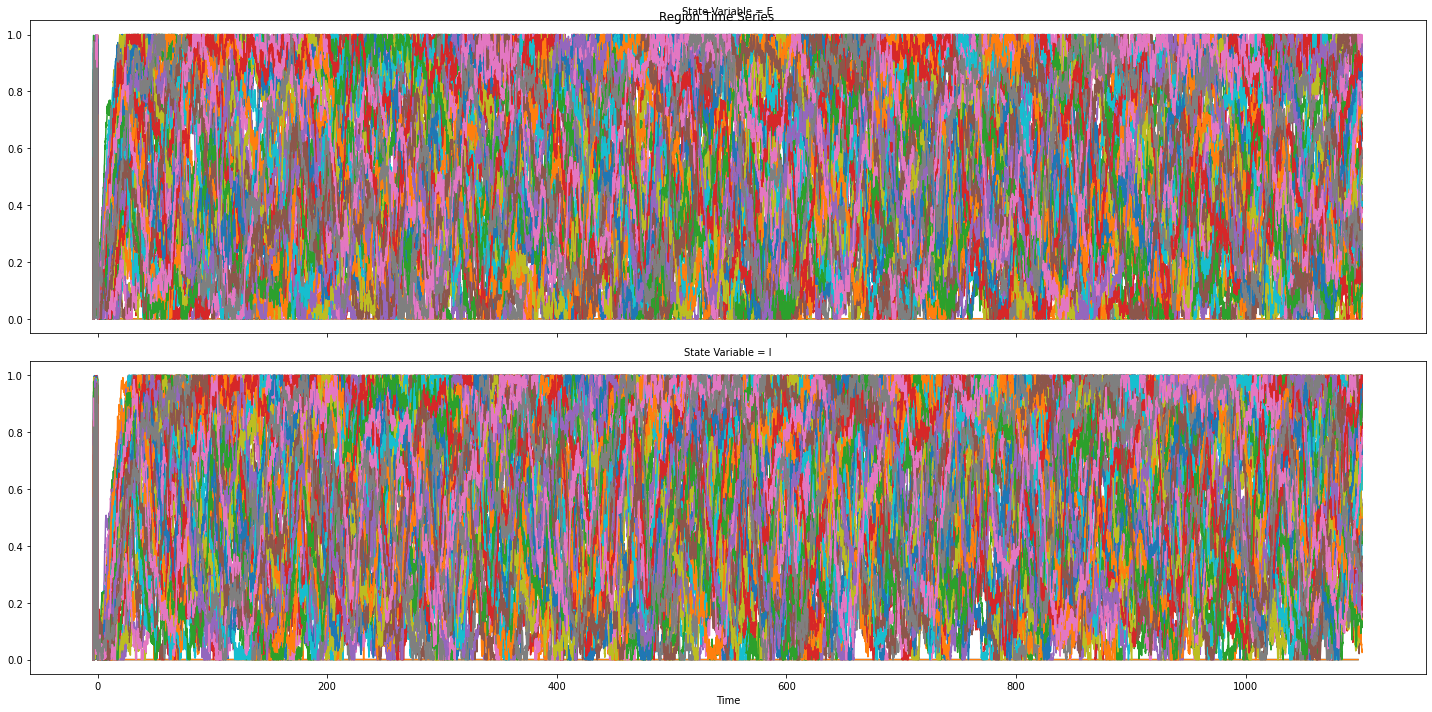

In [13]:
# Plot TVB time series
if source_ts is not None:
    source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:1047: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


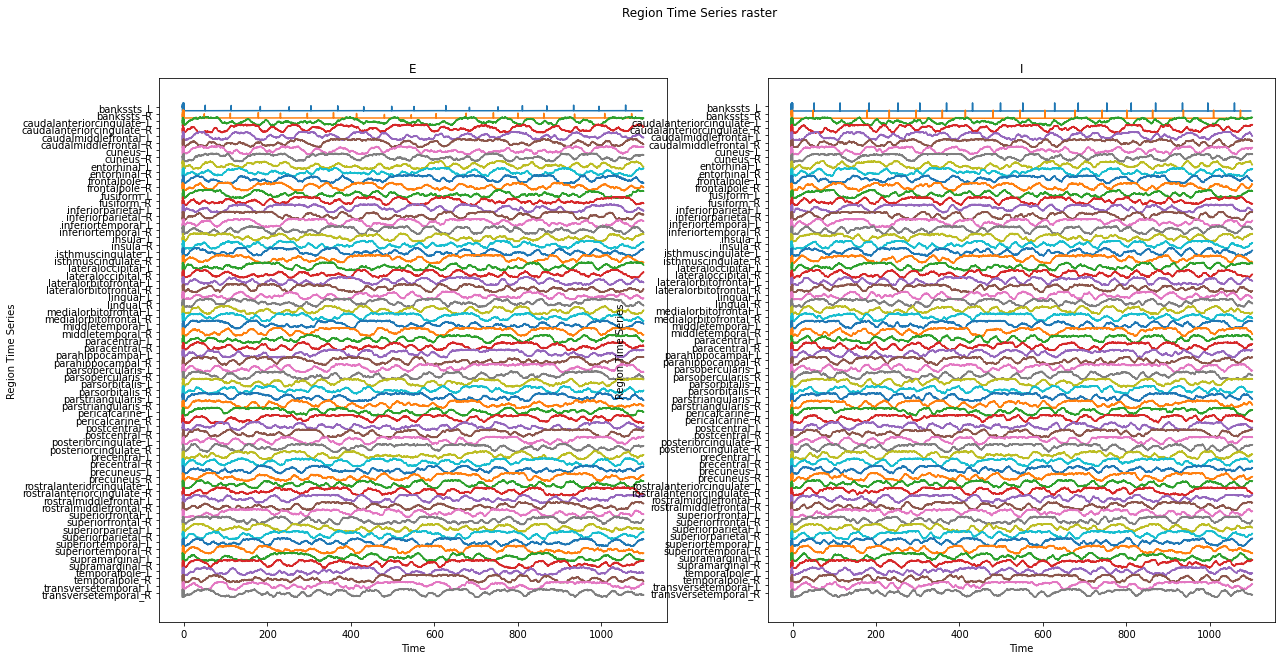

In [14]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

In [15]:
# if source_ts is not None:
#     source_ts_adj = TimeSeriesXarray()
#     source_ts_adj.from_xarray_DataArray(
#                               source_ts._data.copy(),
#                                connectivity=source_ts.connectivity)
#     source_ts_adj.data[:, :, nest_model_builder.spiking_nodes_inds] *= 0.01
#     source_ts_adj.plot_timeseries(plotter_config=plotter.config, 
#                           hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
#                           figsize=FIGSIZE);
# TVB time series raster plot:
# if source_ts_adj is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_adj.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


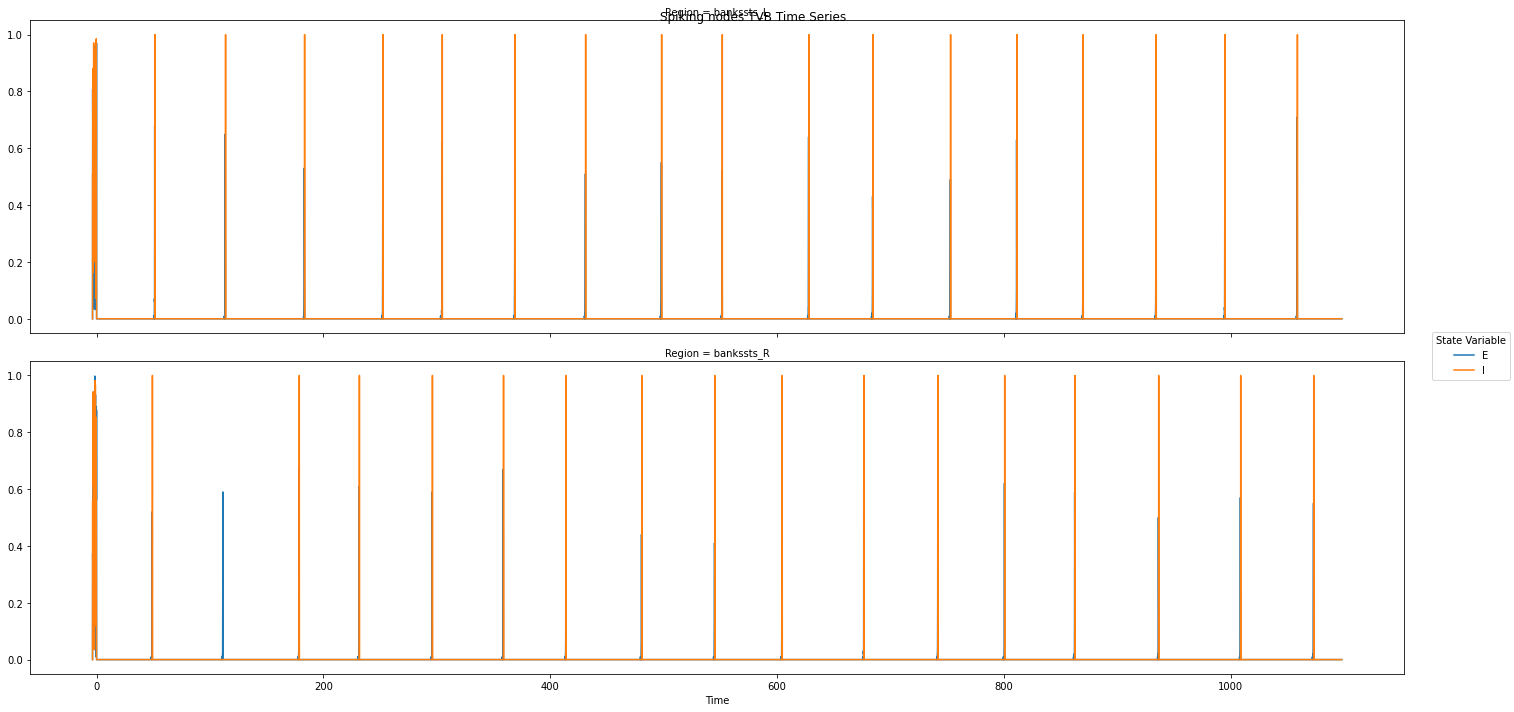

In [16]:
# Focus on the nodes modelled in NEST:
n_spiking_nodes = len(nest_nodes_inds)
if n_spiking_nodes == 0:
    raise Exception("No spiking network simulation to plot!")
source_ts_nest = None
if source_ts is not None and n_spiking_nodes:
    source_ts_nest = source_ts[:, :, nest_nodes_inds]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:1047: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


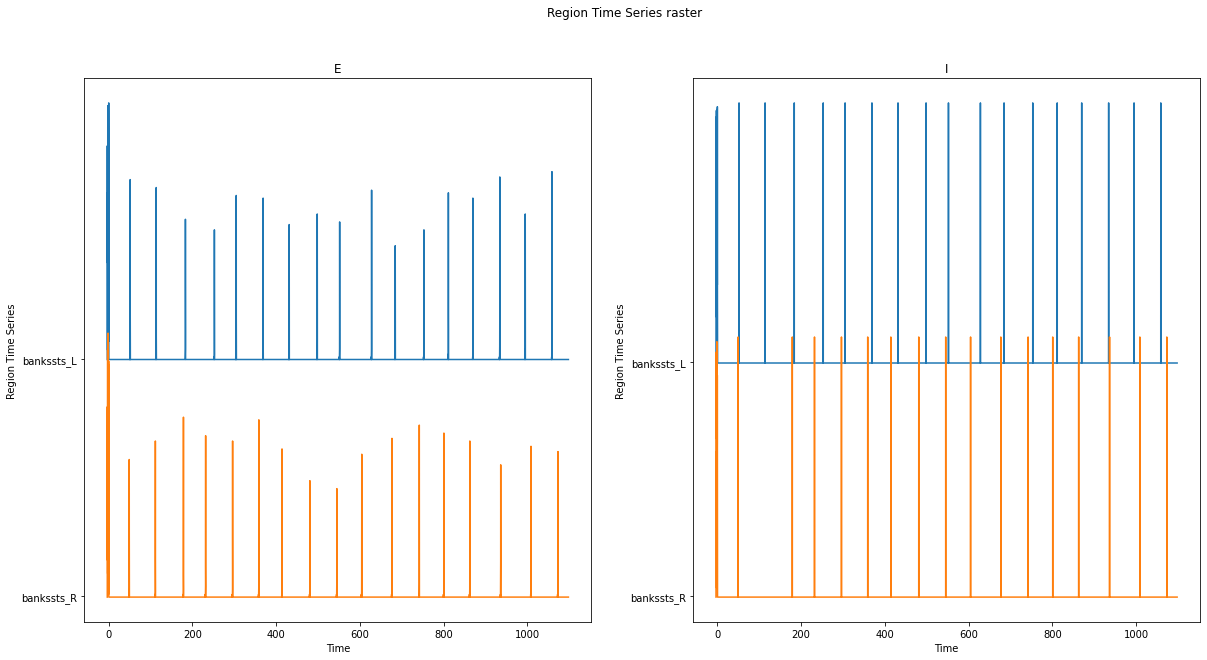

In [17]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts_nest is not None: # and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [18]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [19]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=0.0, end_time=simulation_length, 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [20]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 2, Region: 2)>
array([[16.13814247, 16.13814247],
       [16.13814247, 16.13814247]])
Coordinates:
  * Region      (Region) object 'bankssts_L' 'bankssts_R'
  * Population  (Population) object 'E' 'I'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 2, Population_j: 2, Region_i: 2, Region_j: 2)>
array([[[[ 1.        , -0.00371313],
         [-0.00371313,  1.        ]],

        [[-0.00239743, -0.00239743],
         [-0.00234422, -0.00234422]]],


       [[[-0.00239743, -0.00234422],
         [-0.00239743, -0.00234422]],

        [[ 1.        , -0.00151357],
         [-0.00151357,  1.        ]]]])
Coordinates:
  * Population_i  (Population_i) object 'E' 'I'
  * Region_i      (Region_i) object 'bankssts_L' 'bankssts_R'
  * Population_j  (Population_j) object 'E' 'I'
  * Region_j      (Region_j) object 'bankssts_L' 'bankssts_R'


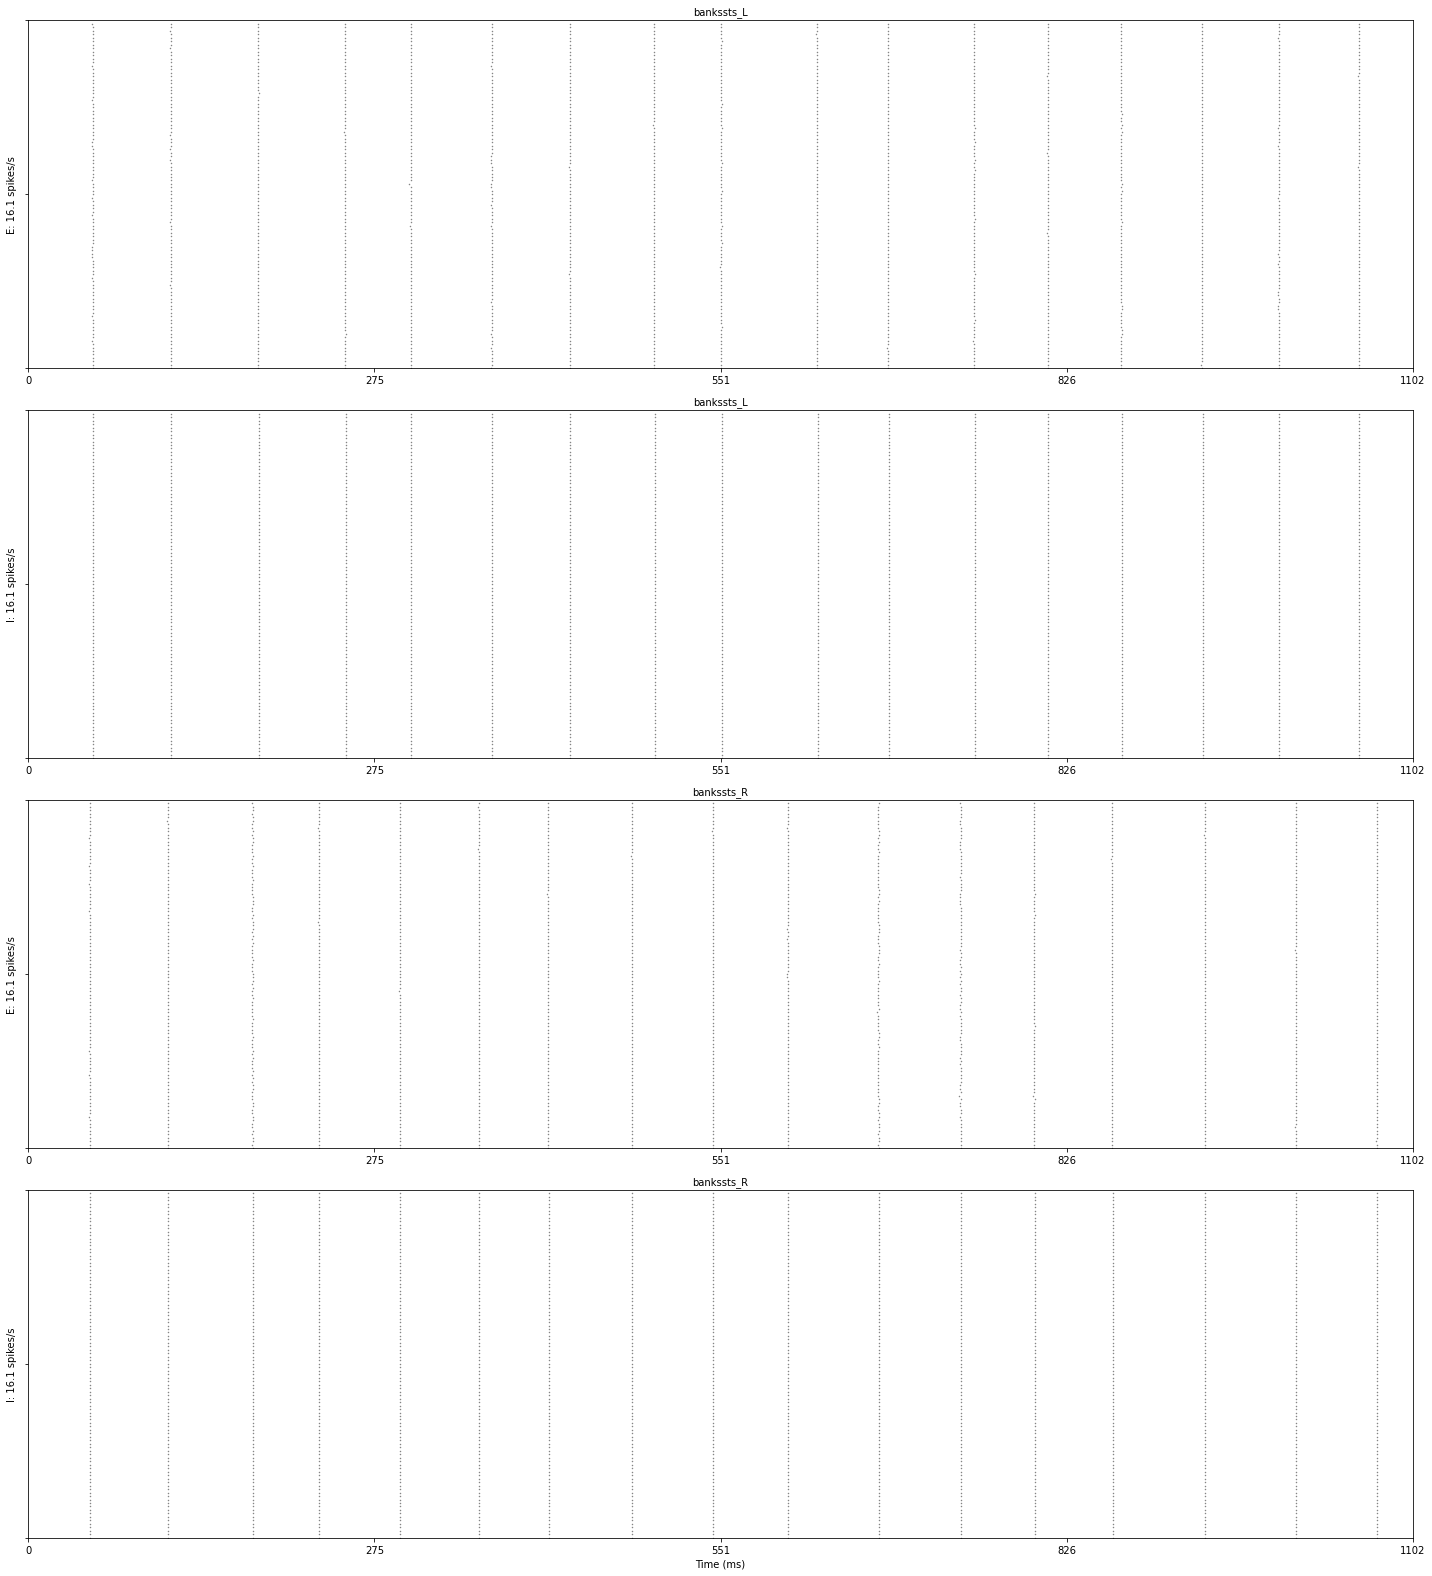

<Figure size 432x288 with 0 Axes>

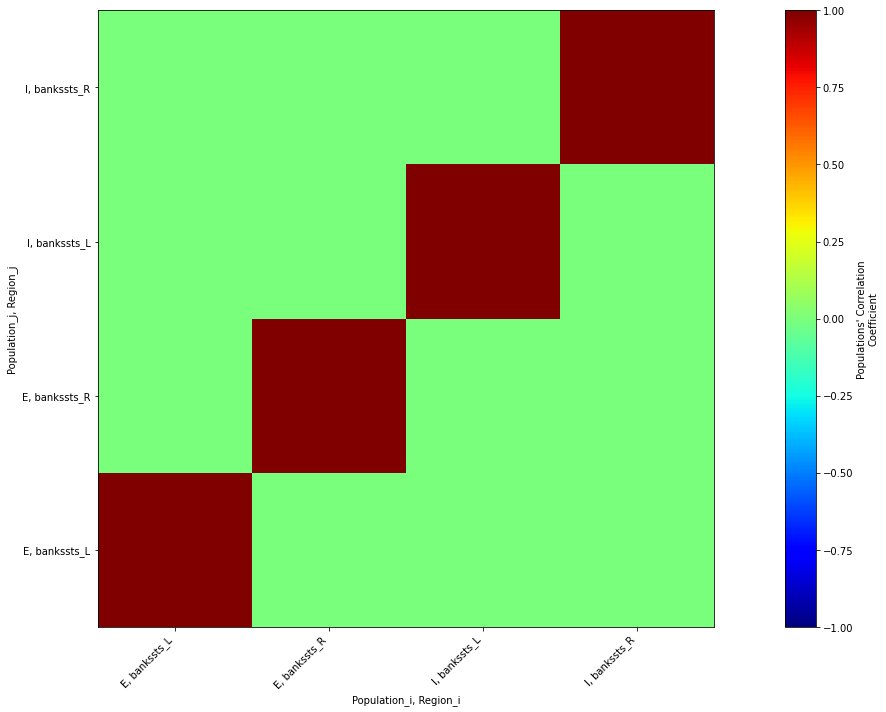

In [21]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [22]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


Mean spike rates:
E - bankssts_L: 16.1381
E - bankssts_R: 16.1381
I - bankssts_L: 16.1381
I - bankssts_R: 16.1381


In [23]:
spikes_sync = None
# spikeNet_analyzer.resample = True
# spikes_sync = \
#     spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
#                                                        comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
#                                                                      spikeNet_analyzer.compute_spikes_sync_time_series, 
#                                                                      spikeNet_analyzer.compute_spikes_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_distance_time_series,
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance_time_series],
#                                                        computations_kwargs=[{}], data_kwargs={},
#                                                        return_spikes_trains=False, return_devices=False)
# # print(spikes_sync)


In [24]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stistimulus=[nest_model_builder.STIM_MF_START, 
                                           nest_model_builder.STIM_IO_START, 
                                           nest_model_builder.STIM_MF_END, 
                                           nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                              )

In [25]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [26]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [27]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [28]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [29]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [30]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


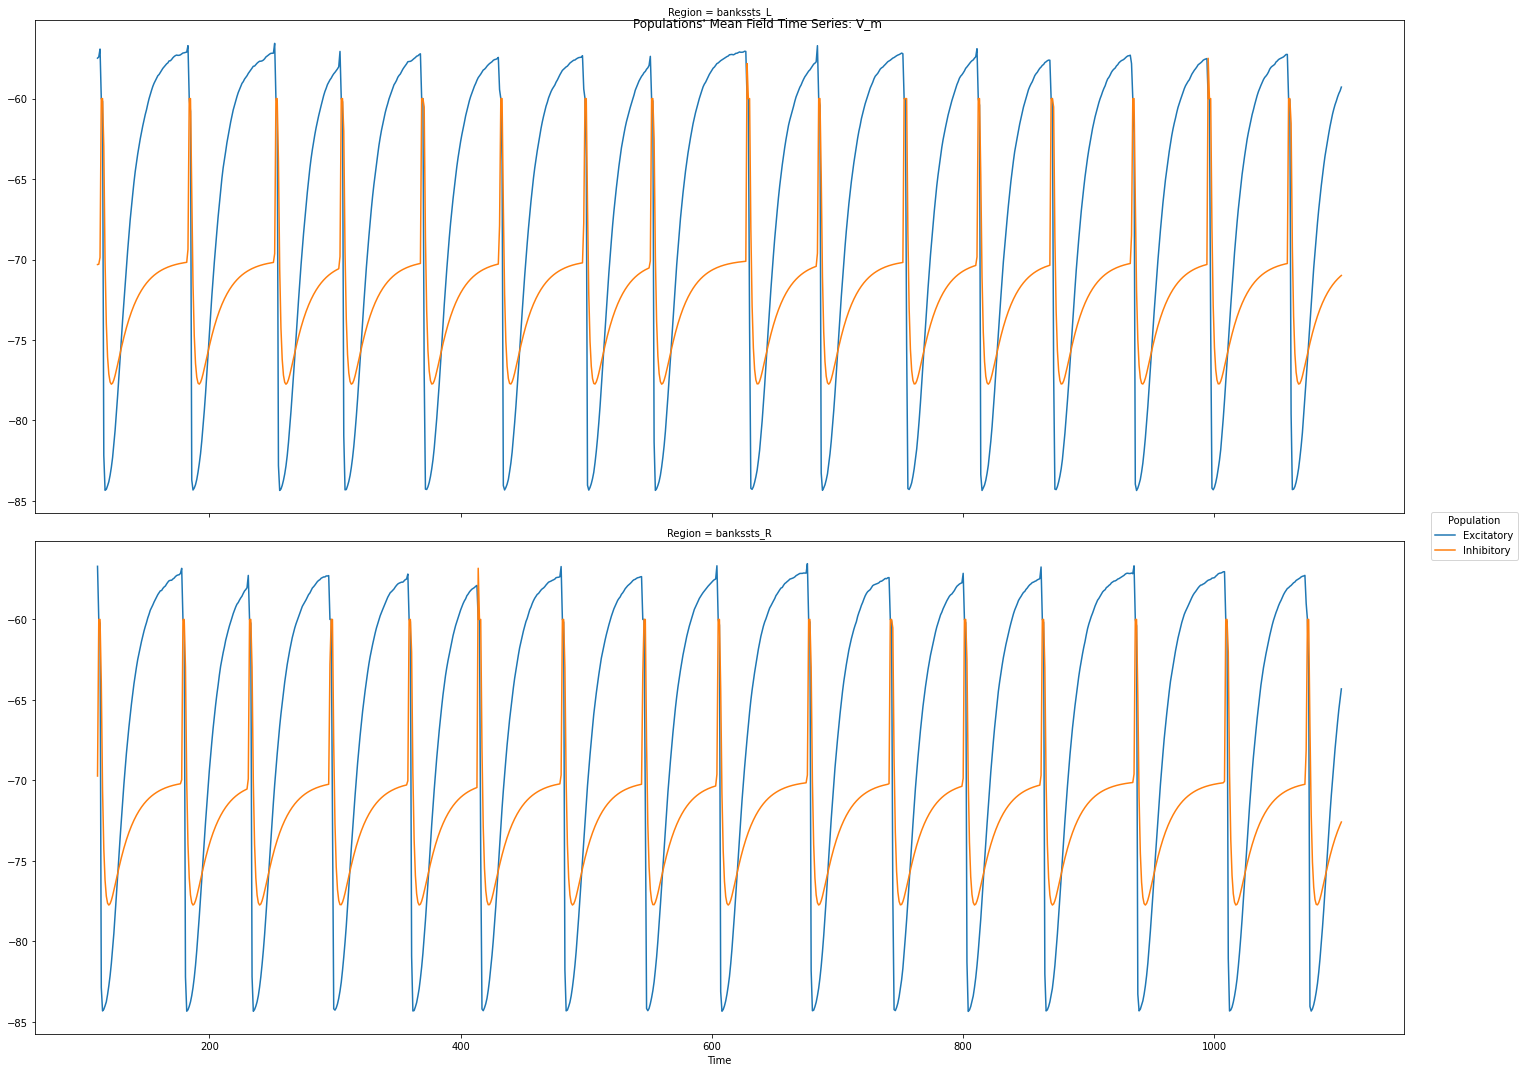

In [31]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
        spikeNet_ts = None
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [32]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [33]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [34]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

In [35]:
if COSIM_MODE.lower().find("ray") > -1:
    ray.shutdown()


# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>